In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection._split import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
from sklearn.ensemble import RandomForestClassifier

def instantiate_RandomForest_model (X_train, y_train):
    param_grid = {
        'max_depth':[3,5,10,None],
        'n_estimators':[10,100,200],
        'max_features':[1,3,5,7],
        'min_samples_leaf':[1,2,3],
        'min_samples_split':[2,3,4]
           }

    # Init classifier
    rf_cl = RandomForestClassifier()

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(rf_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc", error_score='raise')

    # Fit 
    _ = grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
from sklearn.ensemble import RandomForestClassifier

def create_final_cl(X_over, y_over, X_test, y_test, max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators):

    result_accuracy = []
    result_f1 = []
    result_precision = []
    result_recall = []
    result_roc_auc = []

    # parametrizando o modelo final
    final_cl = RandomForestClassifier(max_depth = max_depth, max_features = max_features, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, n_estimators = n_estimators)
    
    #treinando o modelo final
    final_cl.fit(X_over, y_over)

    preds = final_cl.predict(X_test)

    accuracy_score(y_test, preds)

    print('"""Accuracy"""')
    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)
    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('macro: ', f1_score(y_test, preds, average='macro'))
    print('micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('macro: ', precision_score(y_test, preds, average='macro'))
    print('micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas recall_score:"""')
    print('Recall: ', recall_score(y_test, preds))
    print('macro: ', recall_score(y_test, preds, average='macro'))
    print('micro: ', recall_score(y_test, preds, average='micro'))
    print('weighted: ', recall_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""ROC_AUC Score:"""')
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    result_accuracy.append(accuracy_score(y_test, preds))

    result_f1.append(f1_score(y_test, preds))
    result_f1.append(f1_score(y_test, preds, average='macro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))

    result_precision.append(precision_score(y_test, preds))
    result_precision.append(precision_score(y_test, preds, average='macro'))
    result_precision.append(precision_score(y_test, preds, average='micro'))
    result_precision.append(precision_score(y_test, preds, average='weighted'))

    result_recall.append(precision_score(y_test, preds))
    result_recall.append(precision_score(y_test, preds, average='macro'))
    result_recall.append(precision_score(y_test, preds, average='micro'))
    result_recall.append(precision_score(y_test, preds, average='weighted'))

    result_roc_auc.append(roc_auc_score(y_test, preds, multi_class='ovr'))

    return preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc

#### Criação de funções para plotagem de métricas:

In [4]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_feature_importance(final_cl, list_features):
    # plot feature importance
    imp_features = final_cl.feature_importances_
    df_imp_features = pd.DataFrame({"features":list_features}).join(pd.DataFrame({"weights":imp_features}))
    df_imp_features = df_imp_features.sort_values(by=['weights'], ascending=False)
    df_imp_features.plot(x="features", y="weights", kind="bar", figsize=(8, 4))
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [5]:
def apply_periodos (d, df):

    results_accuracy = []
    results_f1 = []
    results_precision = []
    results_recall = []
    results_roc_auc = []

    if d == 90:

        for i in range (0,758,30):
    
            #treino!
            data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
            data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
            data_fim = data_inicio + pd.Timedelta(days = d)
        
            treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
            X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
            y_train = treino['death']

            #teste!
            teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
            X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
            y_test = teste['death']

            oversample = RandomOverSampler(sampling_strategy='minority')
            X_over, y_over = oversample.fit_resample(X_train, y_train)

            print('Início do período: ', data_inicio)
            print('Final do período: ', data_fim)

            ####################################################
            #              APLICANDO O MODELO                  #
            ####################################################

            list_random_states = [0, 12, 42, 50, 54, 68, 79, 81, 92, 112]

            mean_test_scores = []
            std_test_scores = []
            best_scores = []
            best_params = []

            for random_state in list_random_states:

                mean_test_score, std_test_score, best_score, best_param = mean_test_score, std_test_score, best_score, best_param = instantiate_RandomForest_model(X_over, y_over)
                mean_test_scores.append(mean_test_score)
                std_test_scores.append(std_test_score)
                best_scores.append(best_score)
                best_params.append(best_param)

            idx = best_scores.index(max(best_scores))
            best_param = best_params[idx]
        
            preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc = create_final_cl(X_over, y_over, X_test, y_test, best_param['max_depth'], best_param['max_features'], best_param['min_samples_leaf'], best_param['min_samples_split'], best_param['n_estimators'])
            
            results_accuracy.append(result_accuracy)
            results_f1.append(result_f1)
            results_precision.append(result_precision)
            results_recall.append(result_recall)
            results_roc_auc.append(result_roc_auc)

            plot_conf_matrix (X_test, y_test, preds, final_cl)

            plot_roc_curve(y_test, preds)

            plot_feature_importance(final_cl, list_features)

        return results_accuracy, results_f1, results_precision, results_recall, results_roc_auc

    if d == 120:

        for i in range(0,728,30):

            #treino!
            data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
            data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
            data_fim = data_inicio + pd.Timedelta(days = d)

            treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
            X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
            y_train = treino['death']

            #teste!
            teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
            X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
            y_test = teste['death']

            oversample = RandomOverSampler(sampling_strategy='minority')
            X_over, y_over = oversample.fit_resample(X_train, y_train)

            print('Início do período: ', data_inicio)
            print('Final do período: ', data_fim)

            ####################################################
            #              APLICANDO O MODELO                  #
            ####################################################

            list_random_states = [0, 12, 42, 50, 54, 68, 79, 81, 92, 112]

            mean_test_scores = []
            std_test_scores = []
            best_scores = []
            best_params = []

            for random_state in list_random_states:

                mean_test_score, std_test_score, best_score, best_param = mean_test_score, std_test_score, best_score, best_param = instantiate_RandomForest_model(X_over, y_over)

                mean_test_scores.append(mean_test_score)
                std_test_scores.append(std_test_score)
                best_scores.append(best_score)
                best_params.append(best_param)
                
            idx = best_scores.index(max(best_scores))
            best_param = best_params[idx]
        
            preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc = create_final_cl(X_over, y_over, X_test, y_test, best_param['max_depth'], best_param['max_features'], best_param['min_samples_leaf'], best_param['min_samples_split'], best_param['n_estimators'])
        
            results_accuracy.append(result_accuracy)
            results_f1.append(result_f1)
            results_precision.append(result_precision)
            results_recall.append(result_recall)
            results_roc_auc.append(result_roc_auc)

            plot_conf_matrix (X_test, y_test, preds, final_cl)

            plot_roc_curve(y_test, preds)

            plot_feature_importance(final_cl, list_features)
        
        return results_accuracy, results_f1, results_precision, results_recall, results_roc_auc

## Lendo o dataset:

In [6]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']
features = np.array(list_features)

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_13688\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


SYMPTOM_COUGH  SYMPTOM_COLD  SYMPTOM_AIR_INSUFFICIENCY  SYMPTOM_FEVER  \
0                  0             0                          0              1   
1                  0             0                          0              1   
2                  1             0                          1              1   
3                  1             0                          1              1   
4                  1             0                          1              1   
...              ...           ...                        ...            ...   
36430              1             0                          1              1   
36431              1             0                          1              0   
36432              1             0                          1              0   
36433              1             0                          1              0   
36434              1             0                          1              0   

       SYMPTOM_LOW_OXYGEN_SATURATION  SYMPTOM_BREATHING_CONDITION  \
0                                  0                            0   
1                                  0                            0   
2                                  0                            0   
3                                  0                            0   
4                                  0                            0   
...                              ...                          ...   
36430                              0                            0   
36431                              0                            0   
36432                              0                            0   
36433                              0                            0   
36434                              0                            0   

       SYMPTOM_TORACIC_APERTURE  SYMPTOM_THROAT_CONDITION  SYMPTOM_HEADACHE  \
0                             0                         1                 0   
1                             0                         1                 0   
2                             0                         1                 0   
3                             0                         1                 1   
4                             0                         0                 1   
...                         ...                       ...               ...   
36430                         0                         0                 0   
36431                         0                         0                 0   
36432                         0                         0                 0   
36433                         0                         0                 0   
36434                         0                         0                 0   

       SYMPTOM_BODY_PAIN  ...  DISEASE_IMMUNOSUPPRESSION  DISEASE_TABAGIST  \
0                      0  ...                          0                 0   
1                      0  ...                          0                 0   
2                      0  ...                          0                 0   
3                      0  ...                          0                 0   
4                      0  ...                          0                 0   
...                  ...  ...                        ...               ...   
36430                  0  ...                          0                 0   
36431                  0  ...                          0                 0   
36432                  0  ...                          0                 0   
36433                  0  ...                          0                 0   
36434                  0  ...                          0                 0   

       DISEASE_ETILISM  DISEASE_LIVER  DISEASE_NEUROLOGIC  death     idade  \
0                    0              0                   0      0  0.356522   
1                    0              0                   0      0  0.278261   
2                    0              0                   0      0  0.217391   
3                  

### Aplicação do modelo considerando períodos de 90 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-05-26 00:00:00
########################################

best_score: 0.96947994212145
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9685778108052767
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9683305241819451
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9686416010635238
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
#####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


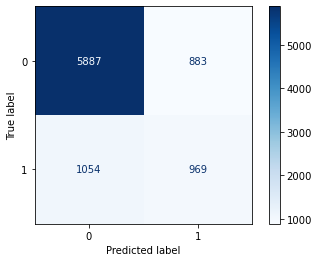

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6770
           1       0.52      0.48      0.50      2023

    accuracy                           0.78      8793
   macro avg       0.69      0.67      0.68      8793
weighted avg       0.77      0.78      0.78      8793

roc_auc_score:  0.6742816181125331


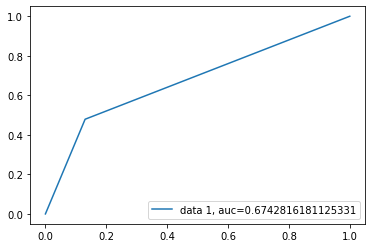

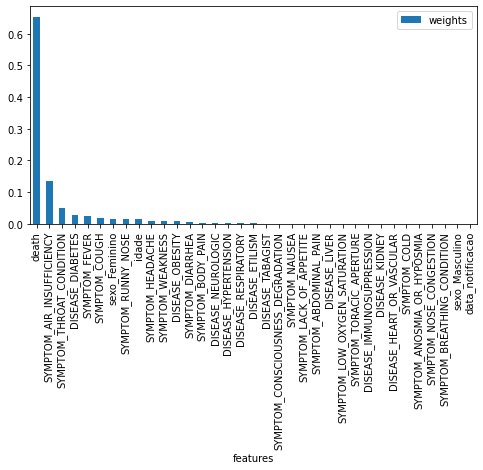

Início do período:  2020-03-27 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.9428257082037762
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9424082422645487
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9425991427287987
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9425285364949098
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


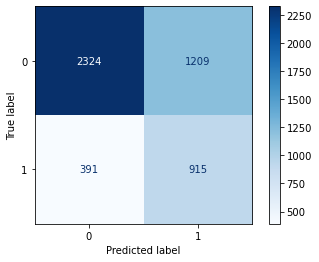

              precision    recall  f1-score   support

           0       0.86      0.66      0.74      3533
           1       0.43      0.70      0.53      1306

    accuracy                           0.67      4839
   macro avg       0.64      0.68      0.64      4839
weighted avg       0.74      0.67      0.69      4839

roc_auc_score:  0.6792052314450192


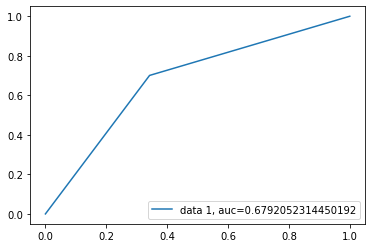

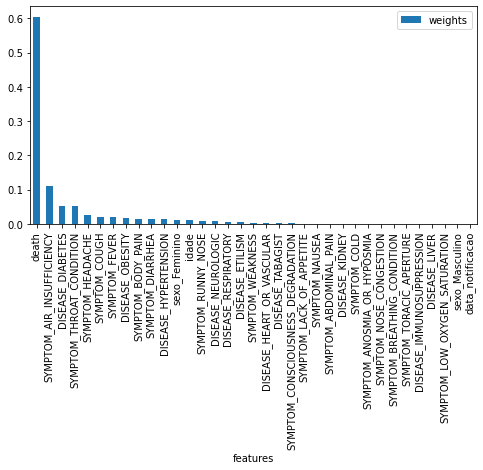

Início do período:  2020-04-26 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.8915447596317513
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8913380146502892
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8914696502292813
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.891790095196346
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


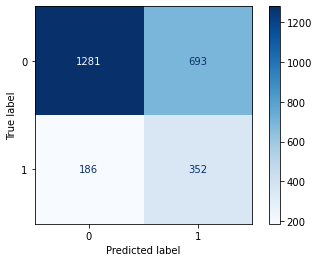

              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1974
           1       0.34      0.65      0.44       538

    accuracy                           0.65      2512
   macro avg       0.61      0.65      0.59      2512
weighted avg       0.76      0.65      0.68      2512

roc_auc_score:  0.6516056315747845


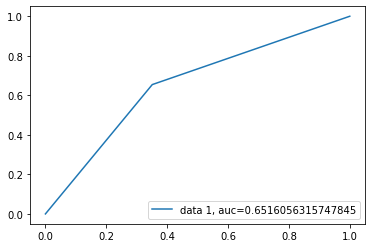

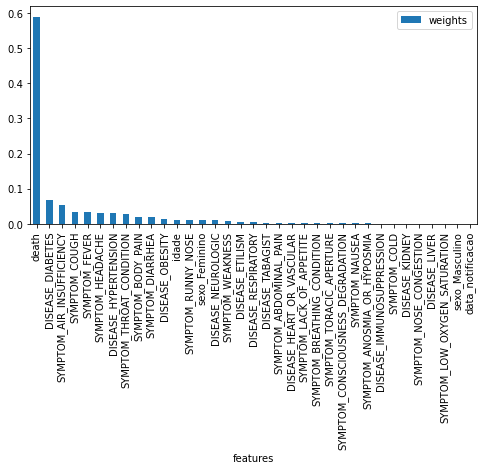

Início do período:  2020-05-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.9110665847262636
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9100632673030429
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9114766402681258
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9103966818060913
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


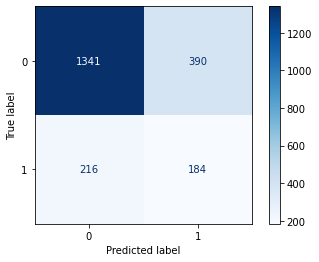

              precision    recall  f1-score   support

           0       0.86      0.77      0.82      1731
           1       0.32      0.46      0.38       400

    accuracy                           0.72      2131
   macro avg       0.59      0.62      0.60      2131
weighted avg       0.76      0.72      0.73      2131

roc_auc_score:  0.6173483535528596


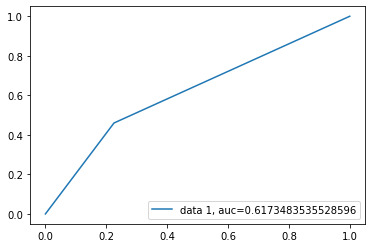

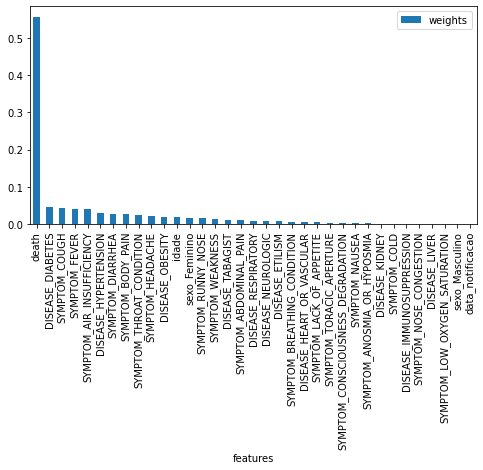

Início do período:  2020-06-25 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.9569749858840332
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9574763033131941
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.957076150007017
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9563861128200092
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


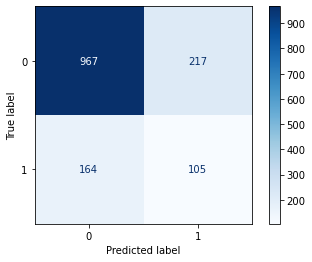

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1184
           1       0.33      0.39      0.36       269

    accuracy                           0.74      1453
   macro avg       0.59      0.60      0.60      1453
weighted avg       0.76      0.74      0.75      1453

roc_auc_score:  0.6035287727318397


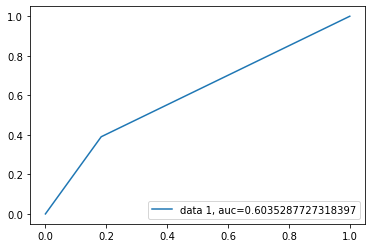

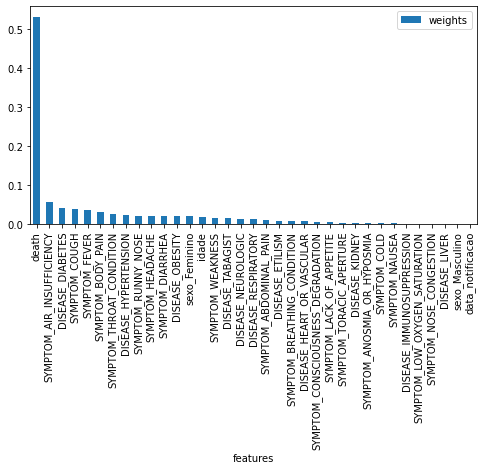

Início do período:  2020-07-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.9646476562782981
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9649704833765945
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9644571417766492
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9644984655281167
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


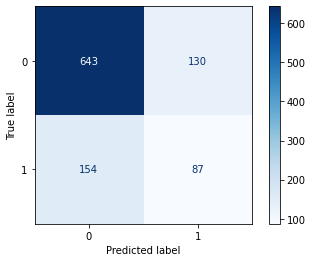

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       773
           1       0.40      0.36      0.38       241

    accuracy                           0.72      1014
   macro avg       0.60      0.60      0.60      1014
weighted avg       0.71      0.72      0.71      1014

roc_auc_score:  0.5964099563590687


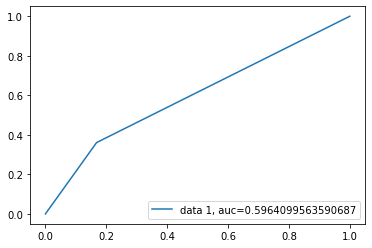

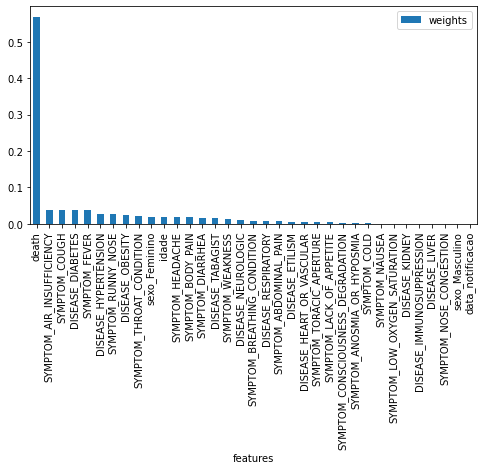

Início do período:  2020-08-24 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.959188166125265
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9591747429461194
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9598646943542107
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9590029262530537
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


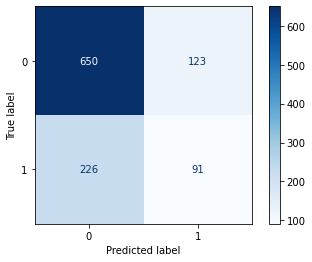

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       773
           1       0.43      0.29      0.34       317

    accuracy                           0.68      1090
   macro avg       0.58      0.56      0.57      1090
weighted avg       0.65      0.68      0.66      1090

roc_auc_score:  0.5639729677890639


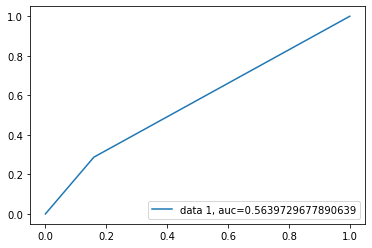

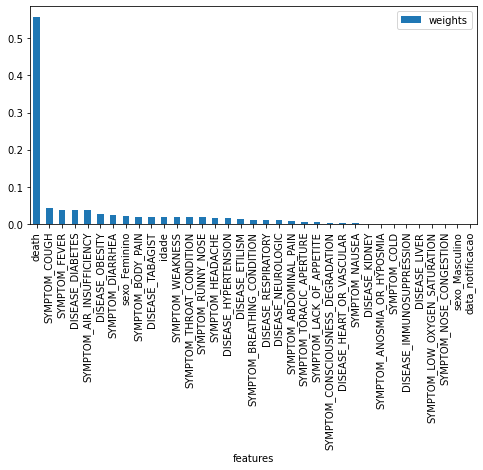

Início do período:  2020-09-23 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.9266175493969178
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9261194736773154
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9270454108003575
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.927210176364657
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


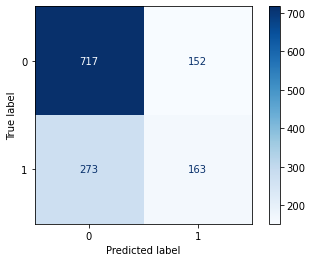

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       869
           1       0.52      0.37      0.43       436

    accuracy                           0.67      1305
   macro avg       0.62      0.60      0.60      1305
weighted avg       0.66      0.67      0.66      1305

roc_auc_score:  0.5994697585540694


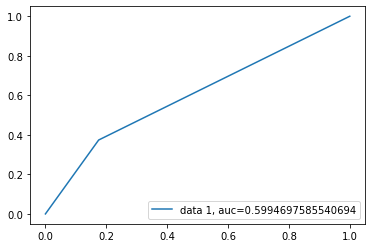

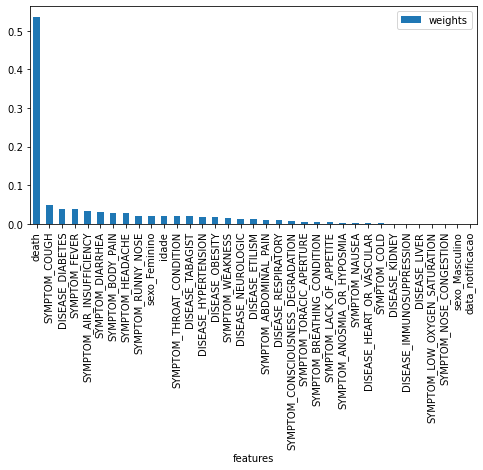

Início do período:  2020-10-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.91949394279408
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9211952520159936
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9199721542956432
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.920334680963115
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
######################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


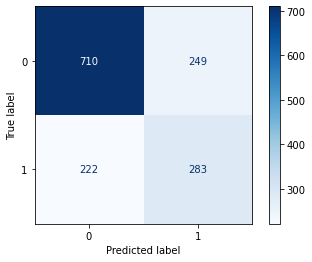

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       959
           1       0.53      0.56      0.55       505

    accuracy                           0.68      1464
   macro avg       0.65      0.65      0.65      1464
weighted avg       0.68      0.68      0.68      1464

roc_auc_score:  0.6503752877894672


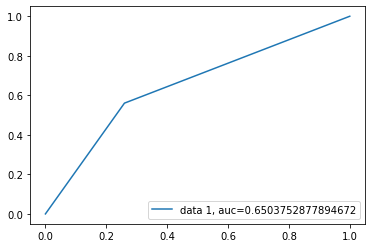

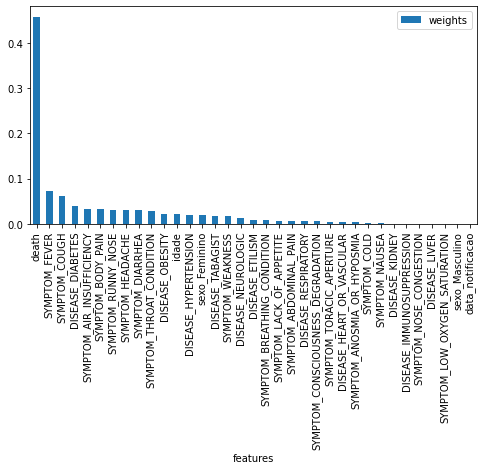

Início do período:  2020-11-22 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8957495627141216
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.897115474386393
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8975964270234943
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8968626709031925
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


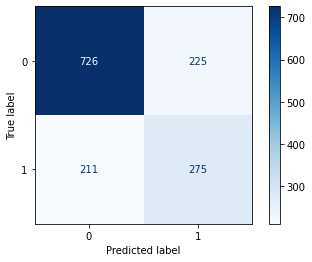

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       951
           1       0.55      0.57      0.56       486

    accuracy                           0.70      1437
   macro avg       0.66      0.66      0.66      1437
weighted avg       0.70      0.70      0.70      1437

roc_auc_score:  0.6646252807311344


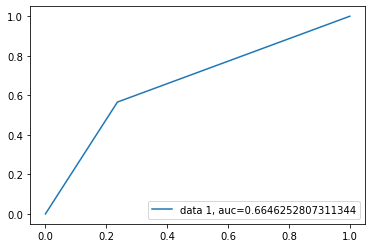

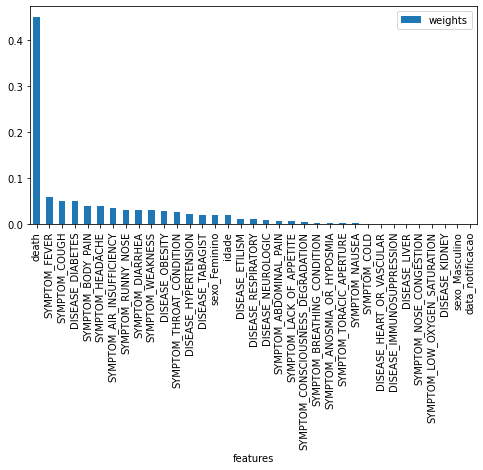

Início do período:  2020-12-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8833185878596698
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8828636787696317
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8824365989542541
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8821176625924251
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


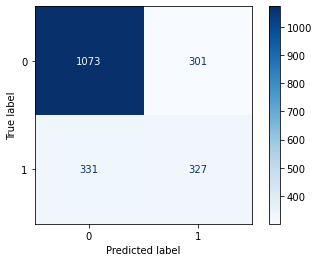

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1374
           1       0.52      0.50      0.51       658

    accuracy                           0.69      2032
   macro avg       0.64      0.64      0.64      2032
weighted avg       0.69      0.69      0.69      2032

roc_auc_score:  0.6389460364653154


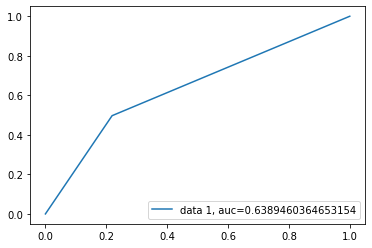

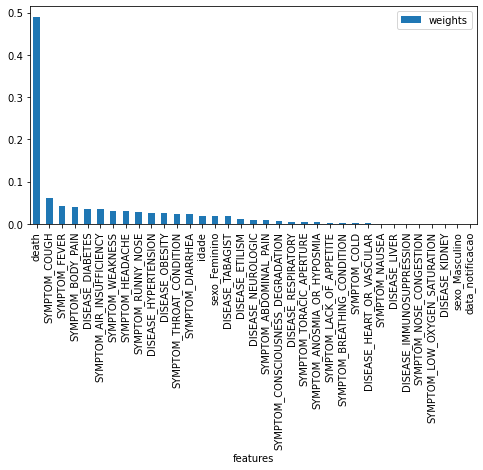

Início do período:  2021-01-21 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.886918942377589
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8862474801722922
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8867707146654515
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8862187177901463
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


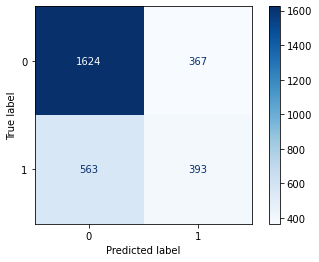

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1991
           1       0.52      0.41      0.46       956

    accuracy                           0.68      2947
   macro avg       0.63      0.61      0.62      2947
weighted avg       0.67      0.68      0.67      2947

roc_auc_score:  0.6133791917183813


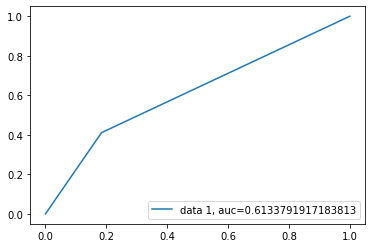

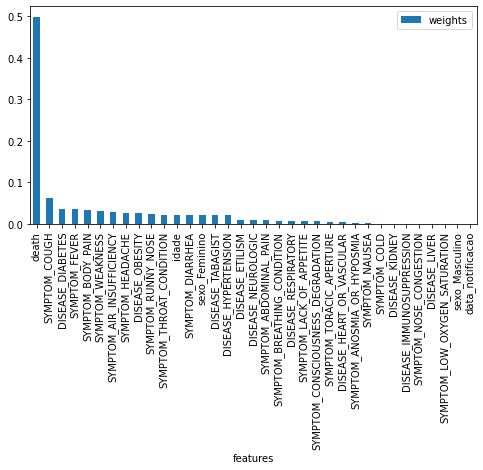

Início do período:  2021-02-20 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8813862082554671
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.880675507354327
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8803209413470455
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8812623983326109
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


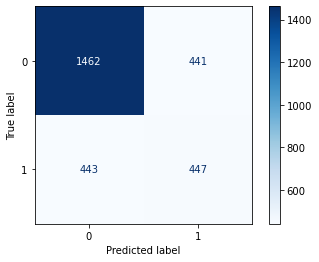

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1903
           1       0.50      0.50      0.50       890

    accuracy                           0.68      2793
   macro avg       0.64      0.64      0.64      2793
weighted avg       0.68      0.68      0.68      2793

roc_auc_score:  0.6352539160521236


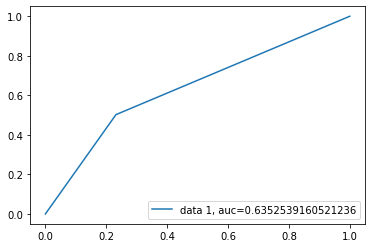

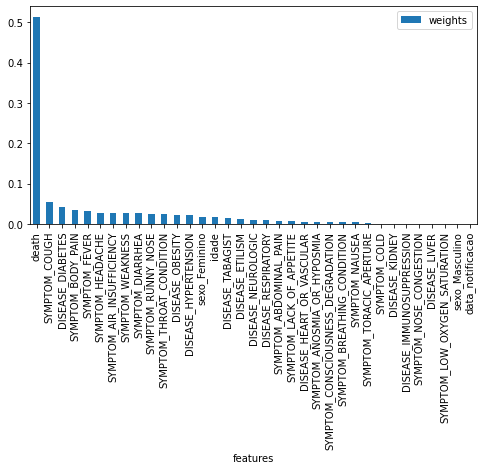

Início do período:  2021-03-22 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.8795732920155344
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8785654290305445
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8792539607433003
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8792347120243627
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


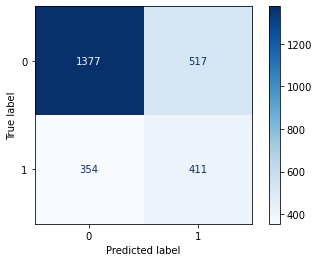

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1894
           1       0.44      0.54      0.49       765

    accuracy                           0.67      2659
   macro avg       0.62      0.63      0.62      2659
weighted avg       0.69      0.67      0.68      2659

roc_auc_score:  0.6321438184566328


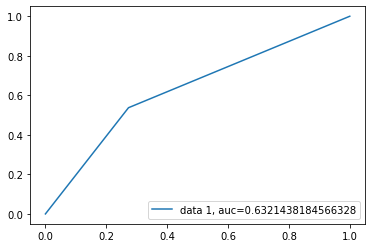

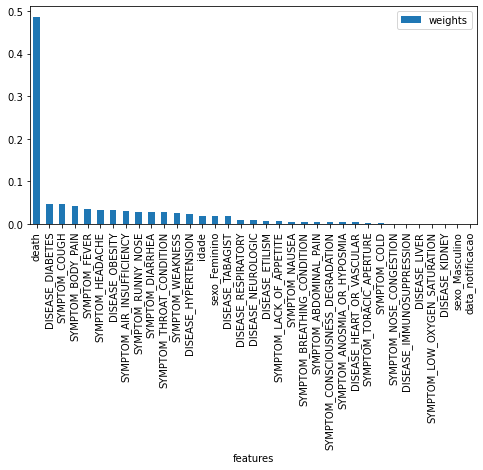

Início do período:  2021-04-21 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8995531964264994
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.899691191183617
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.899860453228543
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.899572977463003
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
######################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


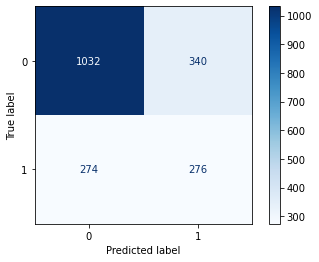

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1372
           1       0.45      0.50      0.47       550

    accuracy                           0.68      1922
   macro avg       0.62      0.63      0.62      1922
weighted avg       0.69      0.68      0.69      1922

roc_auc_score:  0.6270023853697324


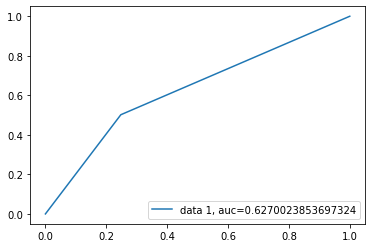

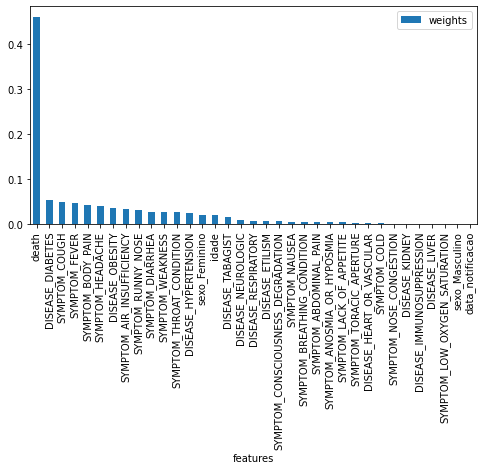

Início do período:  2021-05-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.9113042522985397
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9114850932936722
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9108031368307193
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.911190170362358
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


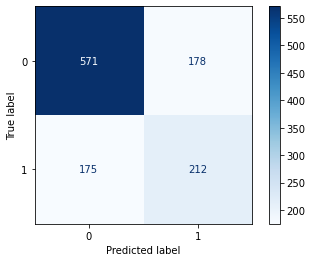

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       749
           1       0.54      0.55      0.55       387

    accuracy                           0.69      1136
   macro avg       0.65      0.66      0.65      1136
weighted avg       0.69      0.69      0.69      1136

roc_auc_score:  0.6550767086520184


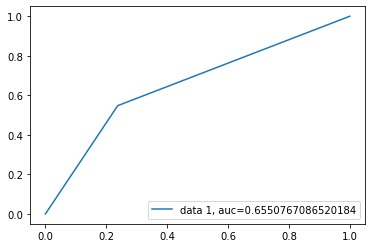

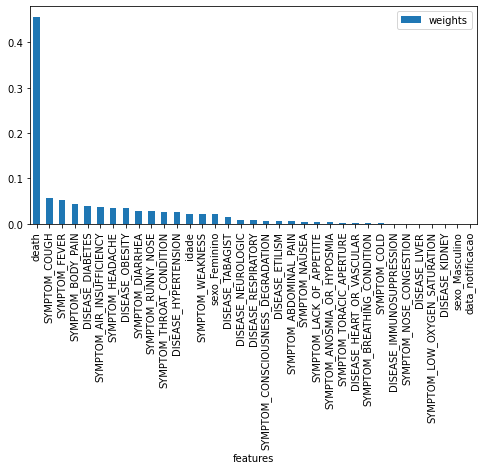

Início do período:  2021-06-20 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8879689107923848
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.887022044635966
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8876476498406369
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8868704308163966
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


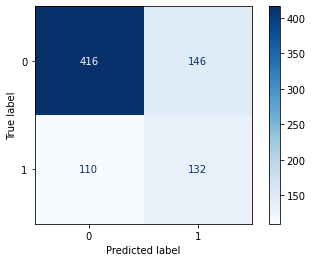

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       562
           1       0.47      0.55      0.51       242

    accuracy                           0.68       804
   macro avg       0.63      0.64      0.64       804
weighted avg       0.70      0.68      0.69       804

roc_auc_score:  0.642834034293109


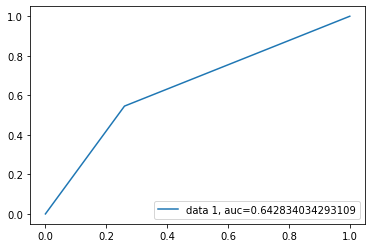

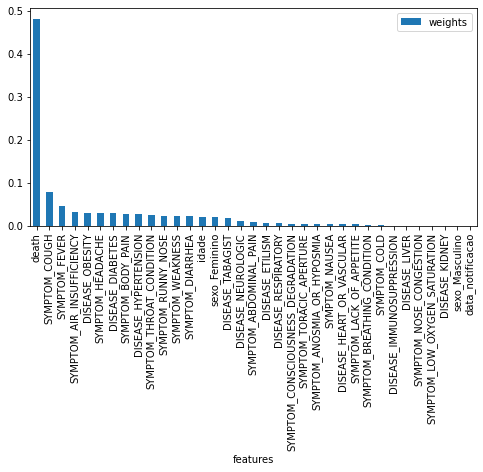

Início do período:  2021-07-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.9096062385059801
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.908295030163746
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9084042924103253
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9087830272762762
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


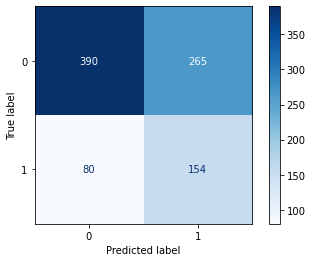

              precision    recall  f1-score   support

           0       0.83      0.60      0.69       655
           1       0.37      0.66      0.47       234

    accuracy                           0.61       889
   macro avg       0.60      0.63      0.58       889
weighted avg       0.71      0.61      0.63       889

roc_auc_score:  0.6267697527239512


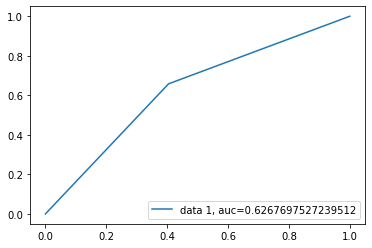

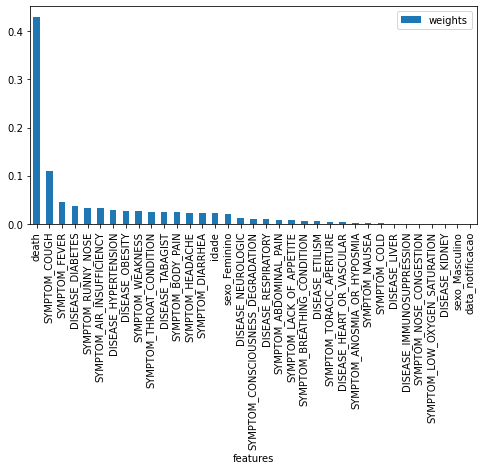

Início do período:  2021-08-19 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.920233154296875
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.921051025390625
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.920263671875
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.919659423828125
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
##########################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


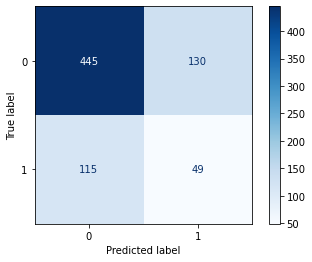

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       575
           1       0.27      0.30      0.29       164

    accuracy                           0.67       739
   macro avg       0.53      0.54      0.53       739
weighted avg       0.68      0.67      0.67       739

roc_auc_score:  0.5363467656415695


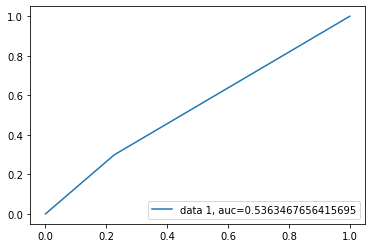

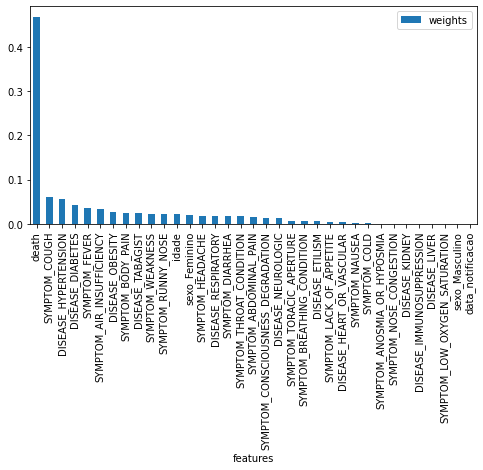

Início do período:  2021-09-18 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.9256807944589698
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9247792761799918
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9247275813036099
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9272986101554974
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


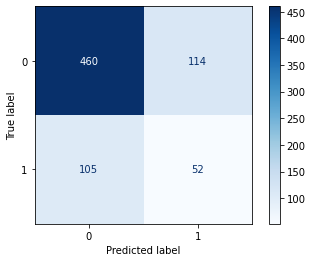

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       574
           1       0.31      0.33      0.32       157

    accuracy                           0.70       731
   macro avg       0.56      0.57      0.56       731
weighted avg       0.71      0.70      0.70       731

roc_auc_score:  0.5663019596528995


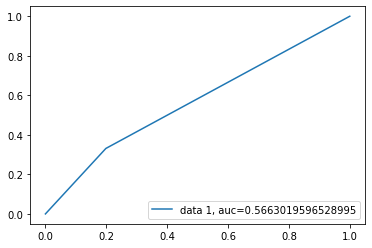

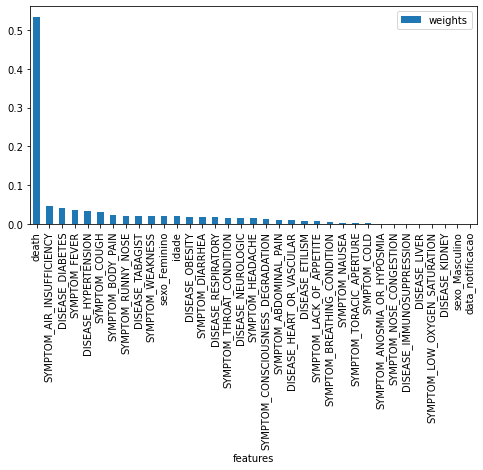

Início do período:  2021-10-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.9597780957336107
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9591317898022893
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9607464099895943
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9592609781477627
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


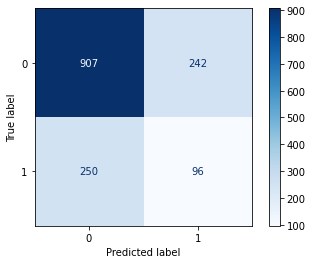

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1149
           1       0.28      0.28      0.28       346

    accuracy                           0.67      1495
   macro avg       0.53      0.53      0.53      1495
weighted avg       0.67      0.67      0.67      1495

roc_auc_score:  0.5334193593826246


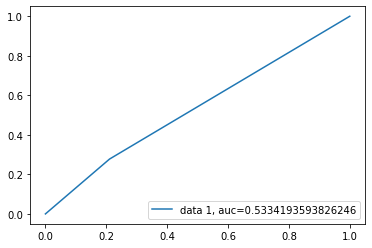

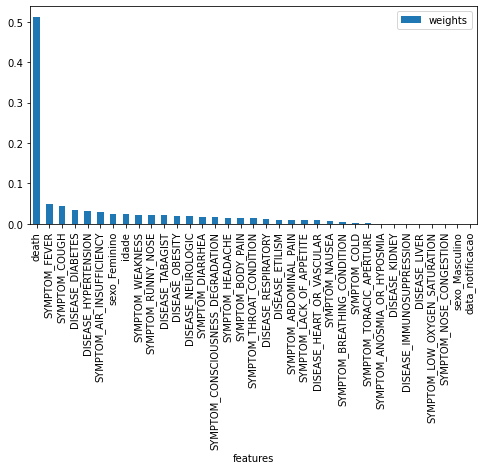

Início do período:  2021-11-17 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.9363443358436149
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9367128665278001
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9364885435026439
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.937377824066656
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


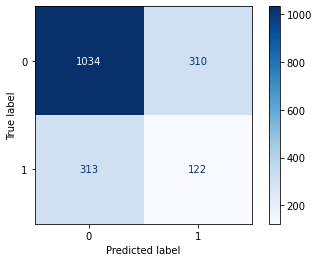

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1344
           1       0.28      0.28      0.28       435

    accuracy                           0.65      1779
   macro avg       0.53      0.52      0.52      1779
weighted avg       0.65      0.65      0.65      1779

roc_auc_score:  0.5249025041050903


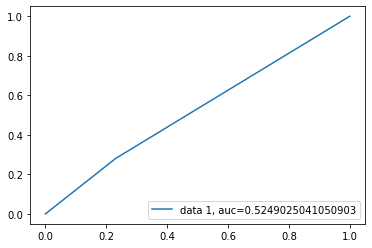

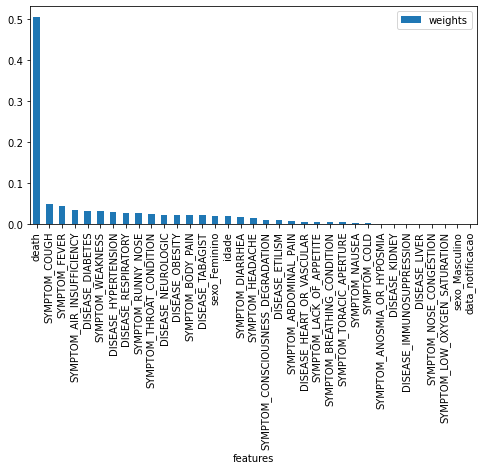

Início do período:  2021-12-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.9137034471735308
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9137087751078907
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9114830305290639
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9114643827588044
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


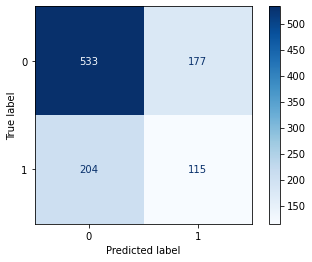

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       710
           1       0.39      0.36      0.38       319

    accuracy                           0.63      1029
   macro avg       0.56      0.56      0.56      1029
weighted avg       0.62      0.63      0.63      1029

roc_auc_score:  0.5556028963751158


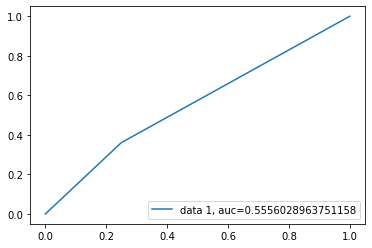

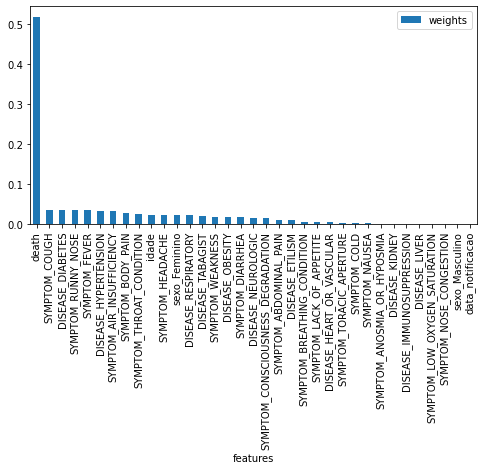

Início do período:  2022-01-16 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.906867388930881
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9065393642837252
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9075150840063122
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9075669774082472
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


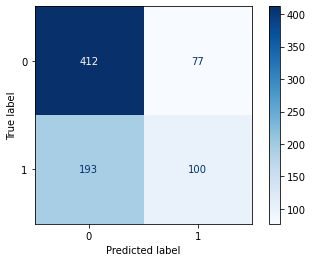

              precision    recall  f1-score   support

           0       0.68      0.84      0.75       489
           1       0.56      0.34      0.43       293

    accuracy                           0.65       782
   macro avg       0.62      0.59      0.59       782
weighted avg       0.64      0.65      0.63       782

roc_auc_score:  0.5919163578243541


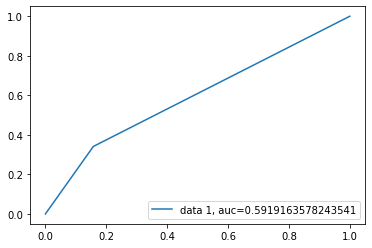

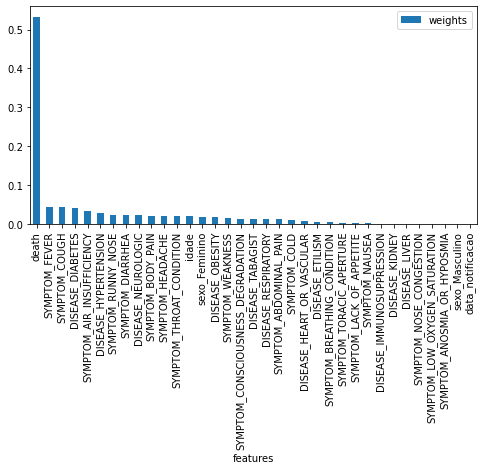

Início do período:  2022-02-15 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.8507930500156895
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8507535026510482
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8498294368261178
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8496784451496653
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


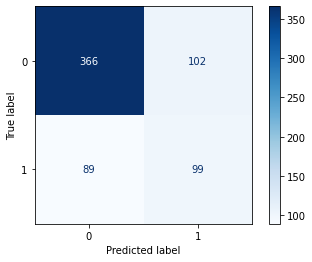

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       468
           1       0.49      0.53      0.51       188

    accuracy                           0.71       656
   macro avg       0.65      0.65      0.65       656
weighted avg       0.72      0.71      0.71       656

roc_auc_score:  0.6543235133660666


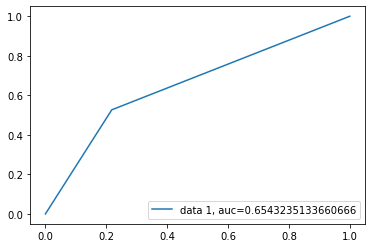

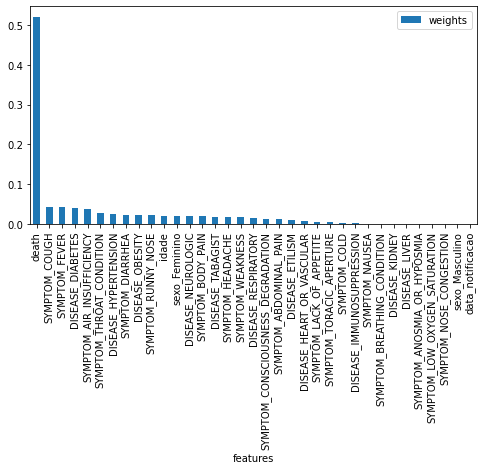

Início do período:  2022-03-17 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8548856090707331
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.855464611075315
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8546021486612256
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8541367992912372
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


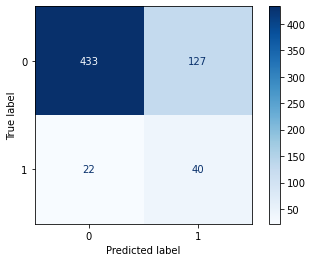

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       560
           1       0.24      0.65      0.35        62

    accuracy                           0.76       622
   macro avg       0.60      0.71      0.60       622
weighted avg       0.88      0.76      0.80       622

roc_auc_score:  0.7091877880184332


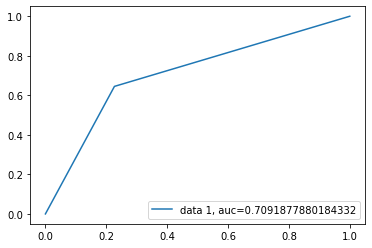

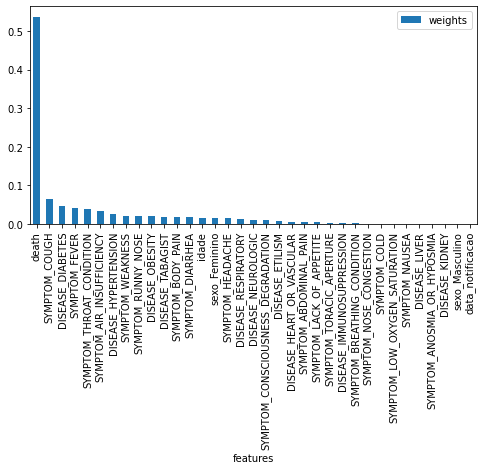

In [9]:
results_accuracy_90_rf, results_f1_90_rf, results_precision_90_rf, results_recall_90_rf, results_roc_auc_90_rf = apply_periodos(90, df)

### Lista com as métricas de cada período:

In [10]:
metricas_accuracy_90_rf = pd.DataFrame(results_accuracy_90_rf)
metricas_accuracy_90_rf.columns = ['accuracy score']
#metricas_accuracy_90_rf
metricas_f1_90_rf = pd.DataFrame(results_f1_90_rf)
metricas_f1_90_rf.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_90_rf
metricas_precision_90_rf = pd.DataFrame(results_precision_90_rf)
metricas_precision_90_rf.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_90_rf
metricas_recall_90_rf = pd.DataFrame(results_recall_90_rf)
metricas_recall_90_rf.columns = ['recall score', 'recall score macro', 'recall score micro', 'recall score weighted']
#metricas_recall_90_rf
metricas_roc_auc_90_rf = pd.DataFrame(results_roc_auc_90_rf)
metricas_roc_auc_90_rf.columns = ['roc_auc score']
#metricas_roc_auc_90_rf
metricas_90_rf = pd.concat([metricas_accuracy_90_rf, metricas_f1_90_rf, metricas_precision_90_rf, metricas_recall_90_rf, metricas_roc_auc_90_rf], axis=1)
metricas_90_rf

accuracy score  f1 score  f1 score macro  f1 score micro  \
0         0.779711  0.500129        0.679428        0.779711   
1         0.669353  0.533528        0.638723        0.669353   
2         0.650080  0.444725        0.594638        0.650080   
3         0.715626  0.377823        0.596758        0.715626   
4         0.737784  0.355330        0.595376        0.737784   
5         0.719921  0.379913        0.599510        0.719921   
6         0.679817  0.342750        0.565553        0.679817   
7         0.674330  0.434088        0.602735        0.674330   
8         0.678279  0.545805        0.648365        0.678279   
9         0.696590  0.557809        0.663439        0.696590   
10        0.688976  0.508554        0.640526        0.688976   
11        0.684425  0.458042        0.617724        0.684425   
12        0.683494  0.502812        0.635335        0.683494   
13        0.672433  0.485529        0.622626        0.672433   
14        0.680541  0.473413        0.622069        0.680541   
15        0.689261  0.545689        0.654784        0.689261   
16        0.681592  0.507692        0.636199        0.681592   
17        0.611924  0.471669        0.582501        0.611924   
18        0.668471  0.285714        0.534928        0.668471   
19        0.700410  0.321981        0.564854        0.700410   
20        0.670903  0.280702        0.533673        0.670903   
21        0.649803  0.281430        0.524959        0.649803   
22        0.629738  0.376432        0.556564        0.629738   
23        0.654731  0.425532        0.589366        0.654731   
24        0.708841  0.508997        0.651032        0.708841   
25        0.760450  0.349345        0.601273        0.760450   

    f1 score weighted  precision score  precision score macro  \
0            0.779711         0.523218               0.685683   
1            0.669353         0.430791               0.643388   
2            0.650080         0.336842               0.605026   
3            0.715626         0.320557               0.590915   
4            0.737784         0.326087               0.590541   
5            0.719921         0.400922               0.603849   
6            0.679817         0.425234               0.583621   
7            0.674330         0.517460               0.620851   
8            0.678279         0.531955               0.646879   
9            0.696590         0.550000               0.662407   
10           0.688976         0.520701               0.642473   
11           0.684425         0.517105               0.629837   
12           0.683494         0.503378               0.635416   
13           0.672433         0.442888               0.619191   
14           0.680541         0.448052               0.619126   
15           0.689261         0.543590               0.654503   
16           0.681592         0.474820               0.632847   
17           0.611924         0.367542               0.598665   
18           0.668471         0.273743               0.534193   
19           0.700410         0.313253               0.563706   
20           0.670903         0.284024               0.533974   
21           0.649803         0.282407               0.525020   
22           0.629738         0.393836               0.558519   
23           0.654731         0.564972               0.622982   
24           0.708841         0.492537               0.648466   
25           0.760450         0.239521               0.595585   

    precision score micro  precision score weighted  recall score  \
0                0.779711                  0.773392      0.523218   
1                0.669353                  0.741229      0.430791   
2                0.650080                  0.758336      0.336842   
3                0.715626                  0.759777      0.320557   
4                0.737784                  0.757077      0.326087   
5                0.719921                  0.710315      0.400922   
6                0.679817           

In [12]:
list_periodos_90 = [['26/02/2020 até 26/05/2020'], ['27/03/2020 até 25/06/2020'], ['26/04/2020 até 25/07/2020'], ['26/05/2020 até 24/08/2020'], 
['25/06/2020 até 23/09/2020'], ['25/07/2020 até 23/10/2020'], ['24/08/2020 até 22/11/2020'], ['23/09/2020 até 22/12/2020'], ['23/10/2020 até 21/01/2021'], 
['22/11/2020 até 20/02/2021'], ['22/12/2020 até 22/03/2022'], ['21/01/2021 até 21/04/2021'], ['20/02/2021 até 21/05/2021'], ['22/03/2021 até 20/06/2021'], 
['21/04/2021 até 20/07/2021'], ['21/05/2021 até 19/08/2021'], ['20/06/2021 até 18/09/2021'], ['20/07/2021 até 18/10/2021'], ['19/08/2021 até 17/11/2021'], 
['18/09/2021 até 17/12/2021'], ['18/10/2021 até 16/01/2022'], ['17/11/2021 até 15/02/2022'], ['17/12/2021 até 17/03/2022'], ['16/01/2022 até 16/04/2022'], 
['15/02/2022 até 16/05/2022'], ['17/03/2022 até 15/06/2022']]

In [13]:
coluna_periodos90 = pd.DataFrame(list_periodos_90)
coluna_periodos90.columns = ['Períodos']
metricas_90_rf_final = pd.concat([coluna_periodos90, metricas_90_rf], axis=1)
metricas_90_rf_final

Períodos  accuracy score  f1 score  f1 score macro  \
0   26/02/2020 até 26/05/2020        0.779711  0.500129        0.679428   
1   27/03/2020 até 25/06/2020        0.669353  0.533528        0.638723   
2   26/04/2020 até 25/07/2020        0.650080  0.444725        0.594638   
3   26/05/2020 até 24/08/2020        0.715626  0.377823        0.596758   
4   25/06/2020 até 23/09/2020        0.737784  0.355330        0.595376   
5   25/07/2020 até 23/10/2020        0.719921  0.379913        0.599510   
6   24/08/2020 até 22/11/2020        0.679817  0.342750        0.565553   
7   23/09/2020 até 22/12/2020        0.674330  0.434088        0.602735   
8   23/10/2020 até 21/01/2021        0.678279  0.545805        0.648365   
9   22/11/2020 até 20/02/2021        0.696590  0.557809        0.663439   
10  22/12/2020 até 22/03/2022        0.688976  0.508554        0.640526   
11  21/01/2021 até 21/04/2021        0.684425  0.458042        0.617724   
12  20/02/2021 até 21/05/2021        0.683494  0.502812        0.635335   
13  22/03/2021 até 20/06/2021        0.672433  0.485529        0.622626   
14  21/04/2021 até 20/07/2021        0.680541  0.473413        0.622069   
15  21/05/2021 até 19/08/2021        0.689261  0.545689        0.654784   
16  20/06/2021 até 18/09/2021        0.681592  0.507692        0.636199   
17  20/07/2021 até 18/10/2021        0.611924  0.471669        0.582501   
18  19/08/2021 até 17/11/2021        0.668471  0.285714        0.534928   
19  18/09/2021 até 17/12/2021        0.700410  0.321981        0.564854   
20  18/10/2021 até 16/01/2022        0.670903  0.280702        0.533673   
21  17/11/2021 até 15/02/2022        0.649803  0.281430        0.524959   
22  17/12/2021 até 17/03/2022        0.629738  0.376432        0.556564   
23  16/01/2022 até 16/04/2022        0.654731  0.425532        0.589366   
24  15/02/2022 até 16/05/2022        0.708841  0.508997        0.651032   
25  17/03/2022 até 15/06/2022        0.760450  0.349345        0.601273   

    f1 score micro  f1 score weighted  precision score  precision score macro  \
0         0.779711           0.779711         0.523218               0.685683   
1         0.669353           0.669353         0.430791               0.643388   
2         0.650080           0.650080         0.336842               0.605026   
3         0.715626           0.715626         0.320557               0.590915   
4         0.737784           0.737784         0.326087               0.590541   
5         0.719921           0.719921         0.400922               0.603849   
6         0.679817           0.679817         0.425234               0.583621   
7         0.674330           0.674330         0.517460               0.620851   
8         0.678279           0.678279         0.531955               0.646879   
9         0.696590           0.696590         0.550000               0.662407   
10        0.688976           0.688976         0.520701               0.642473   
11        0.684425           0.684425         0.517105               0.629837   
12        0.683494           0.683494         0.503378               0.635416   
13        0.672433           0.672433         0.442888               0.619191   
14        0.680541           0.680541         0.448052               0.619126   
15        0.689261           0.689261         0.543590               0.654503   
16        0.681592           0.681592         0.474820               0.632847   
17        0.611924           0.611924         0.367542               0.598665   
18        0.668471           0.668471         0.273743               0.534193   
19        0.700410           0.700410         0.313253               0.563706   
20        0.670903           0.670903         0.284024               0.533974   
21        0.649803           0.649803         0.282407               0.525020   
22        0.629738           0.629738         0.393836               0.558519   
23        0.654731           0.654731         0.564

### Aplicação do modelo considerando períodos de 120 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.9641587167720964
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.964608286446353
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9643425425094735
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9639412930265138
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


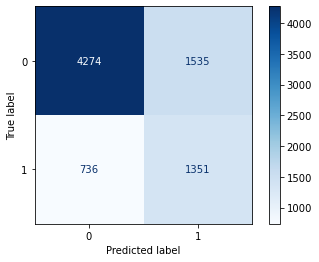

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      5809
           1       0.47      0.65      0.54      2087

    accuracy                           0.71      7896
   macro avg       0.66      0.69      0.67      7896
weighted avg       0.75      0.71      0.72      7896

roc_auc_score:  0.6915477717729448


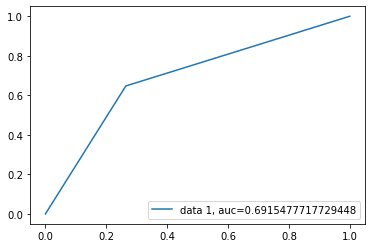

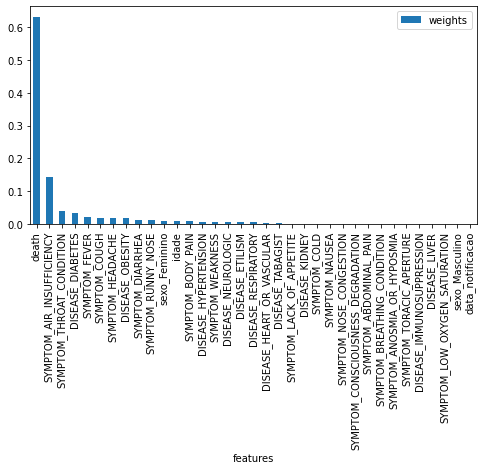

Início do período:  2020-03-27 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.9205712279628662
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.920622473207273
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9207389585000516
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9205862786665426
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


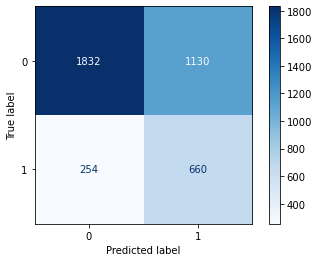

              precision    recall  f1-score   support

           0       0.88      0.62      0.73      2962
           1       0.37      0.72      0.49       914

    accuracy                           0.64      3876
   macro avg       0.62      0.67      0.61      3876
weighted avg       0.76      0.64      0.67      3876

roc_auc_score:  0.6703008346421557


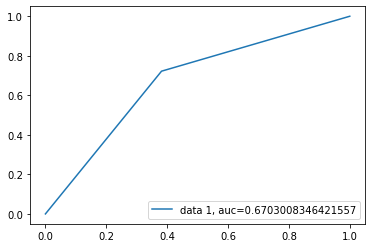

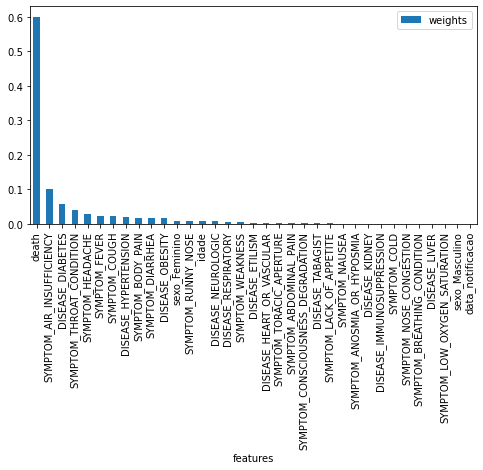

Início do período:  2020-04-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8778053636755947
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8773743800178554
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8770198208088159
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8771165046142203
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


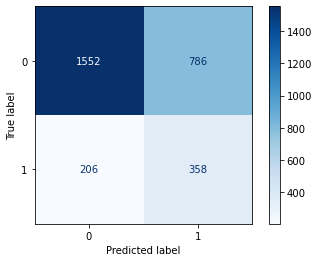

              precision    recall  f1-score   support

           0       0.88      0.66      0.76      2338
           1       0.31      0.63      0.42       564

    accuracy                           0.66      2902
   macro avg       0.60      0.65      0.59      2902
weighted avg       0.77      0.66      0.69      2902

roc_auc_score:  0.6492834998695617


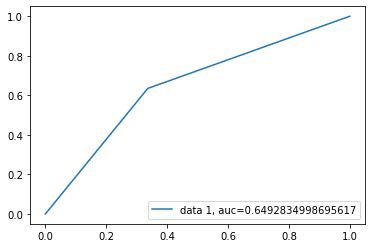

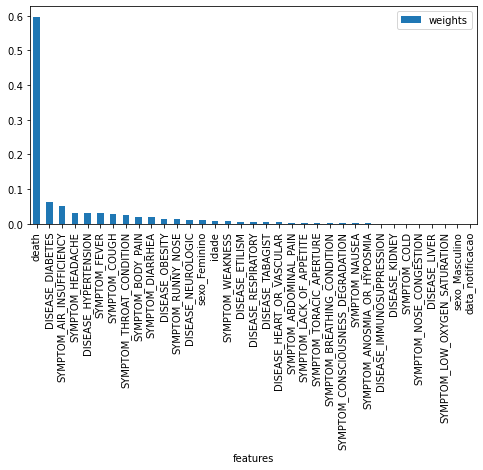

Início do período:  2020-05-26 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.9082356936168916
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.907933752471531
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9082623231487548
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9083350240469862
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


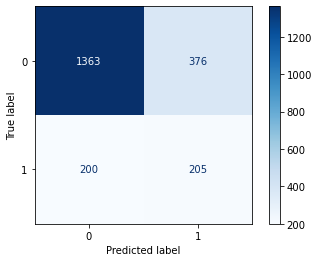

              precision    recall  f1-score   support

           0       0.87      0.78      0.83      1739
           1       0.35      0.51      0.42       405

    accuracy                           0.73      2144
   macro avg       0.61      0.64      0.62      2144
weighted avg       0.77      0.73      0.75      2144

roc_auc_score:  0.6449783116449783


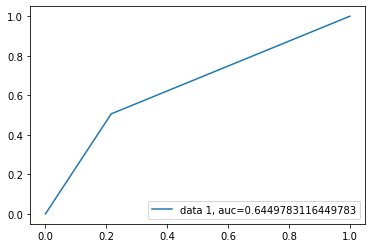

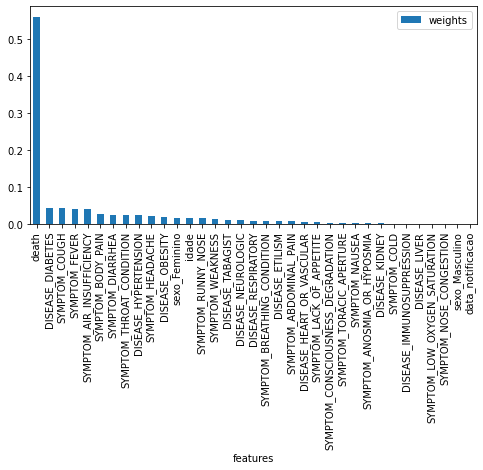

Início do período:  2020-06-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.9531741411735478
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9538069690755648
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.953077133663992
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9528126021504439
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


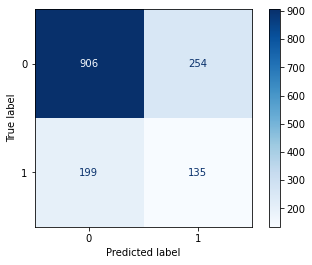

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1160
           1       0.35      0.40      0.37       334

    accuracy                           0.70      1494
   macro avg       0.58      0.59      0.59      1494
weighted avg       0.71      0.70      0.70      1494

roc_auc_score:  0.5926130497625439


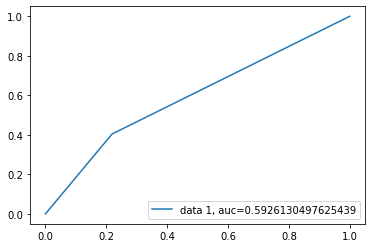

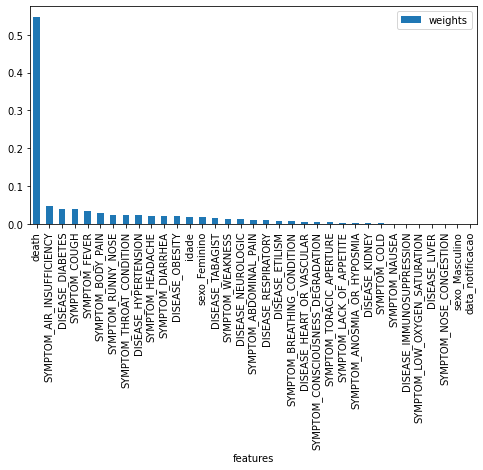

Início do período:  2020-07-25 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.9603160511363636
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9606001420454545
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9599948347107439
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9596074380165289
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


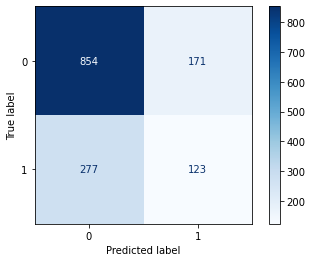

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1025
           1       0.42      0.31      0.35       400

    accuracy                           0.69      1425
   macro avg       0.59      0.57      0.57      1425
weighted avg       0.66      0.69      0.67      1425

roc_auc_score:  0.5703353658536585


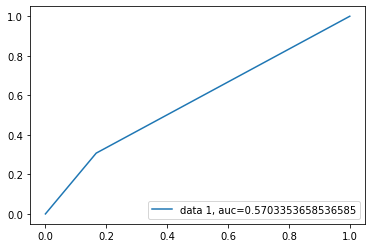

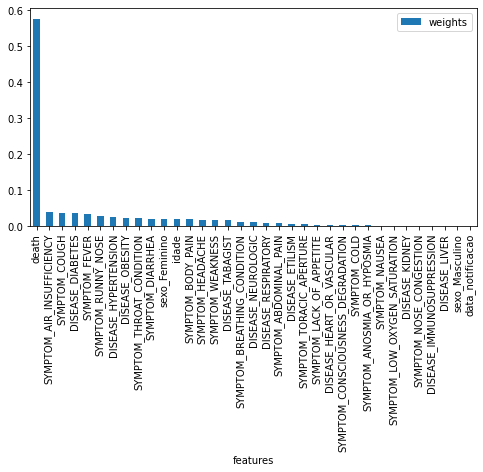

Início do período:  2020-08-24 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.9476396440929313
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9476767177459218
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9487677423910741
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9478885671915827
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


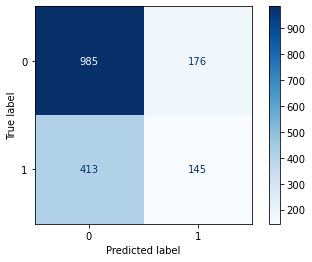

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1161
           1       0.45      0.26      0.33       558

    accuracy                           0.66      1719
   macro avg       0.58      0.55      0.55      1719
weighted avg       0.62      0.66      0.63      1719

roc_auc_score:  0.5541315884526687


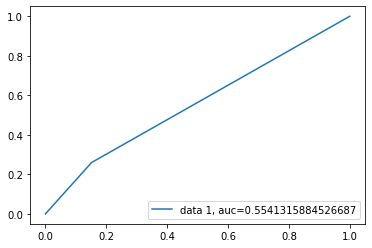

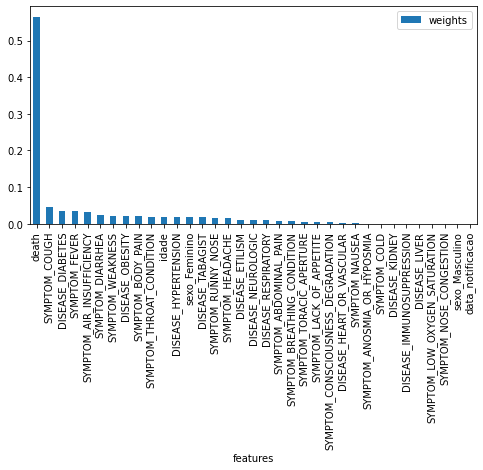

Início do período:  2020-09-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.925916653104623
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9263434777419741
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.926002886002886
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9257408239212751
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
#####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


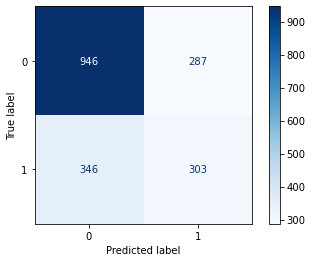

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1233
           1       0.51      0.47      0.49       649

    accuracy                           0.66      1882
   macro avg       0.62      0.62      0.62      1882
weighted avg       0.66      0.66      0.66      1882

roc_auc_score:  0.6170532493061256


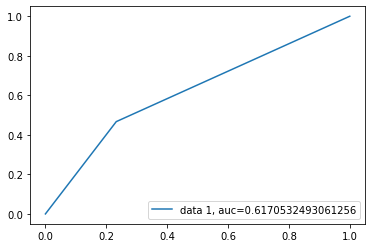

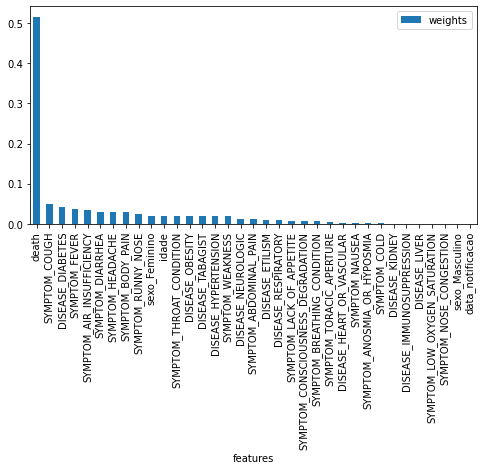

Início do período:  2020-10-23 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.9106926979734471
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9099752332432723
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9113244729980836
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9099742483912063
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


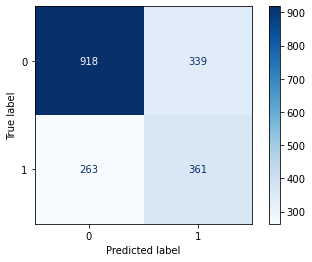

              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1257
           1       0.52      0.58      0.55       624

    accuracy                           0.68      1881
   macro avg       0.65      0.65      0.65      1881
weighted avg       0.69      0.68      0.68      1881

roc_auc_score:  0.654417951777737


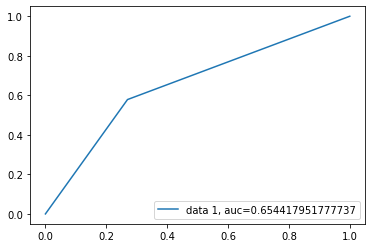

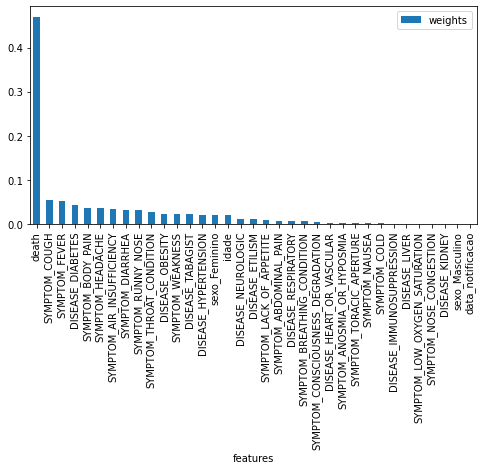

Início do período:  2020-11-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8847179884195416
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8857050692730762
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8856518443250915
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8857986161513525
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


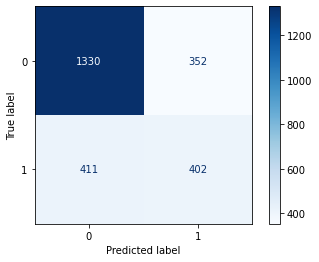

              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1682
           1       0.53      0.49      0.51       813

    accuracy                           0.69      2495
   macro avg       0.65      0.64      0.65      2495
weighted avg       0.69      0.69      0.69      2495

roc_auc_score:  0.6425951358205615


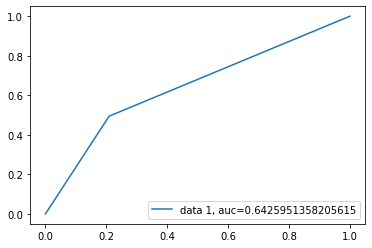

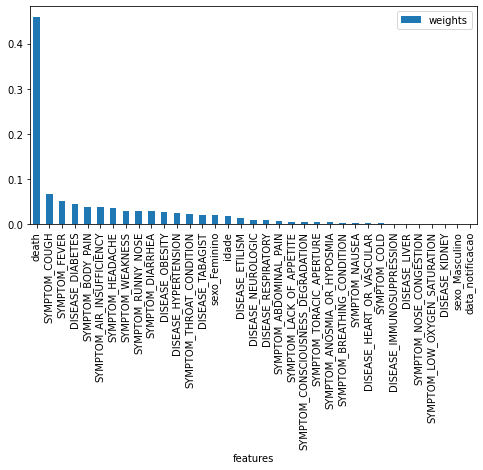

Início do período:  2020-12-22 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8819827639655278
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8798670097340195
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8793183086366174
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8814294128588258
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


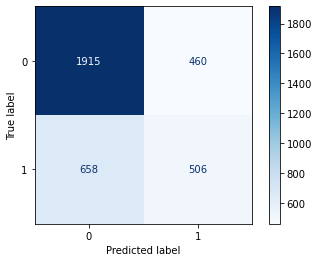

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      2375
           1       0.52      0.43      0.48      1164

    accuracy                           0.68      3539
   macro avg       0.63      0.62      0.62      3539
weighted avg       0.67      0.68      0.68      3539

roc_auc_score:  0.6205118466268765


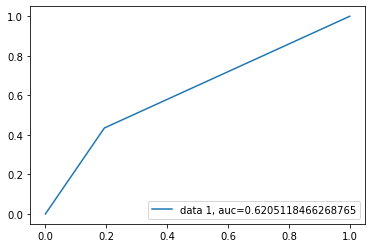

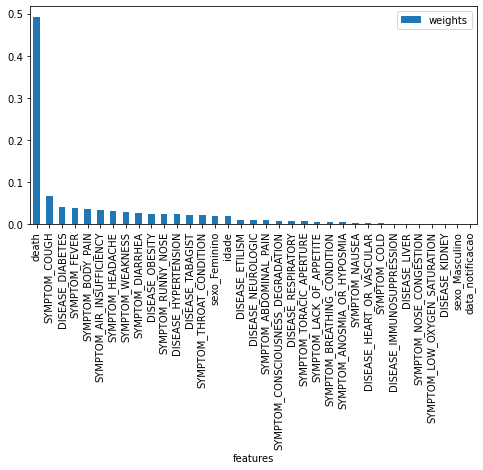

Início do período:  2021-01-21 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8887888205018042
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8893415433939069
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8898738349048122
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.889565273160722
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


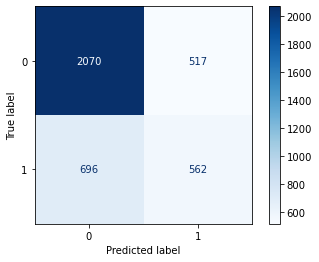

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      2587
           1       0.52      0.45      0.48      1258

    accuracy                           0.68      3845
   macro avg       0.63      0.62      0.63      3845
weighted avg       0.67      0.68      0.68      3845

roc_auc_score:  0.6234477388778304


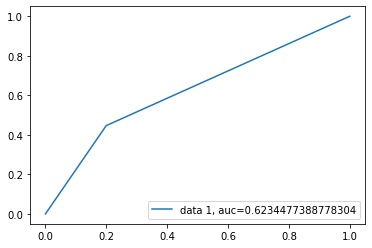

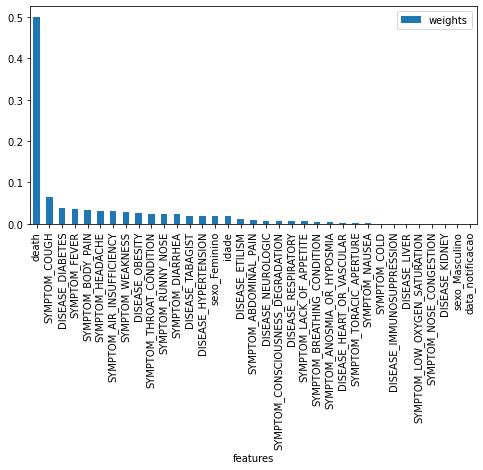

Início do período:  2021-02-20 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.884883743975467
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8854529391559357
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8846943009684434
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8847019083069714
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


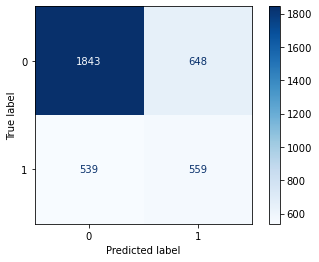

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      2491
           1       0.46      0.51      0.49      1098

    accuracy                           0.67      3589
   macro avg       0.62      0.62      0.62      3589
weighted avg       0.68      0.67      0.67      3589

roc_auc_score:  0.6244854883774668


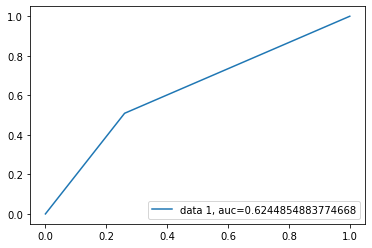

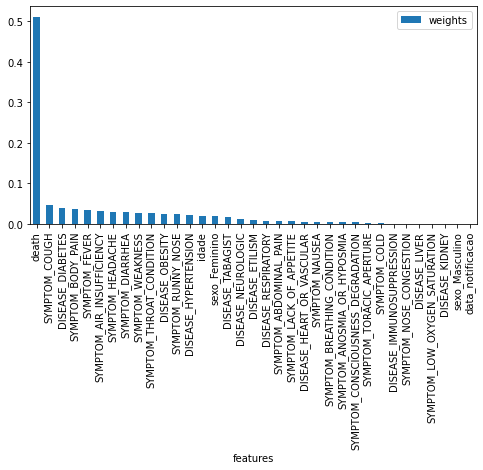

Início do período:  2021-03-22 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8891015673598174
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8892155177759398
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8881043044089459
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8896667815078889
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


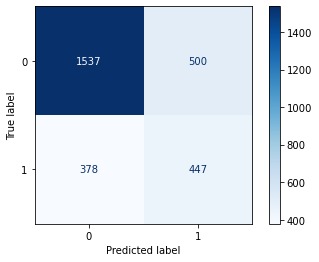

              precision    recall  f1-score   support

           0       0.80      0.75      0.78      2037
           1       0.47      0.54      0.50       825

    accuracy                           0.69      2862
   macro avg       0.64      0.65      0.64      2862
weighted avg       0.71      0.69      0.70      2862

roc_auc_score:  0.6481795867362878


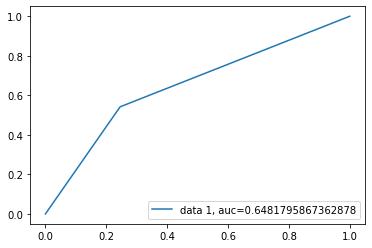

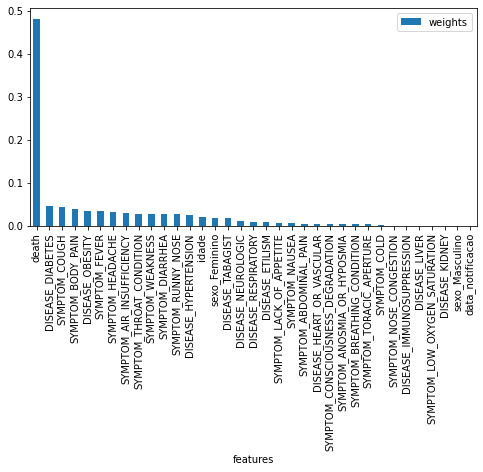

Início do período:  2021-04-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.9006298815822624
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9015085663895187
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9008578199798437
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9011219765684052
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


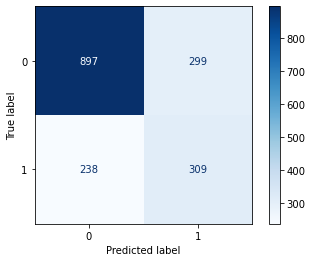

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1196
           1       0.51      0.56      0.54       547

    accuracy                           0.69      1743
   macro avg       0.65      0.66      0.65      1743
weighted avg       0.70      0.69      0.70      1743

roc_auc_score:  0.6574497257769653


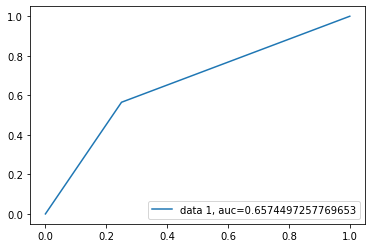

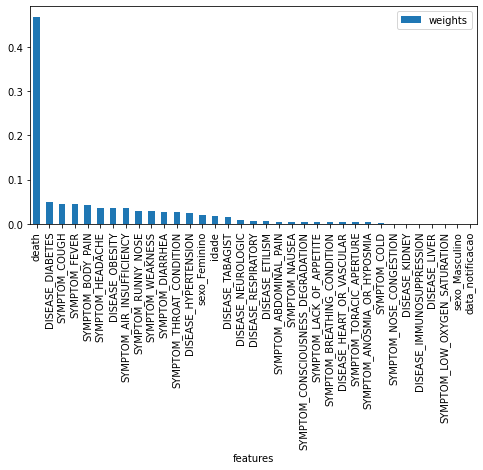

Início do período:  2021-05-21 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.9045008583918621
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9060283939278895
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9060108352780911
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9055234278169211
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


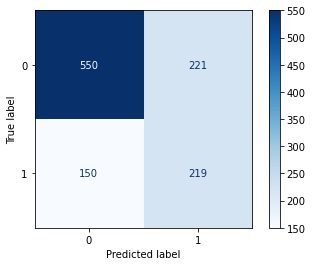

              precision    recall  f1-score   support

           0       0.79      0.71      0.75       771
           1       0.50      0.59      0.54       369

    accuracy                           0.67      1140
   macro avg       0.64      0.65      0.64      1140
weighted avg       0.69      0.67      0.68      1140

roc_auc_score:  0.6534276043149537


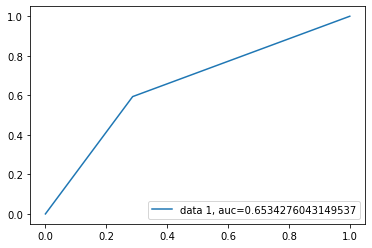

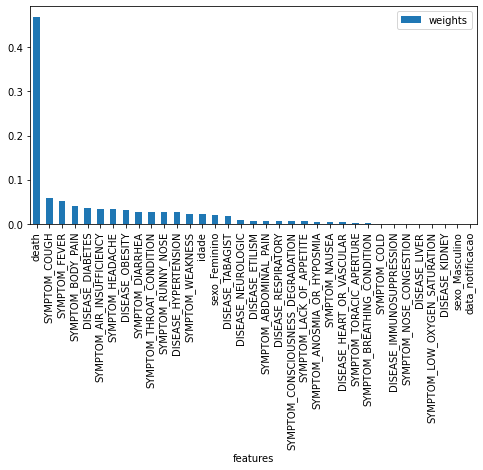

Início do período:  2021-06-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.9033987546172701
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9023206792251862
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9021800479308485
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9015315681307653
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


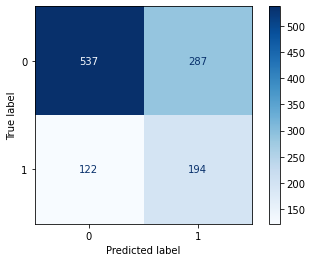

              precision    recall  f1-score   support

           0       0.81      0.65      0.72       824
           1       0.40      0.61      0.49       316

    accuracy                           0.64      1140
   macro avg       0.61      0.63      0.61      1140
weighted avg       0.70      0.64      0.66      1140

roc_auc_score:  0.6328115398795625


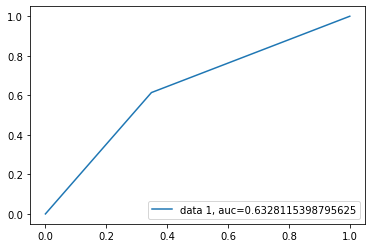

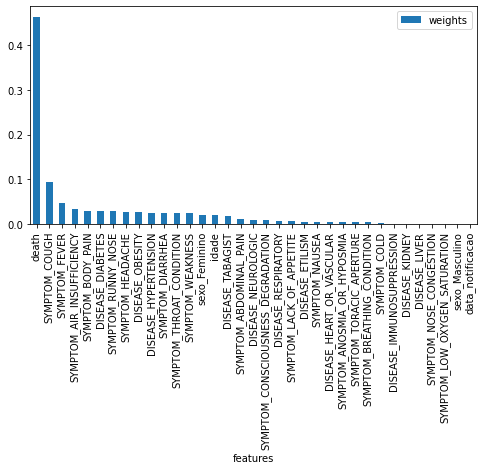

Início do período:  2021-07-20 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.8886016607704402
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8891958284198115
best_params_: {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8869964376965409
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8893511939858492
best_params_: {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


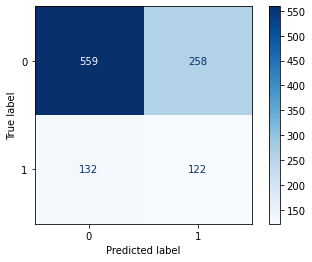

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       817
           1       0.32      0.48      0.38       254

    accuracy                           0.64      1071
   macro avg       0.57      0.58      0.56      1071
weighted avg       0.69      0.64      0.66      1071

roc_auc_score:  0.5822627434728554


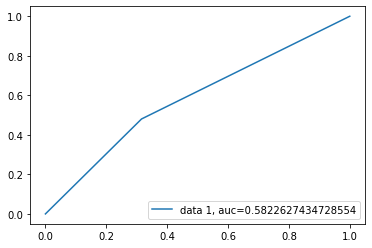

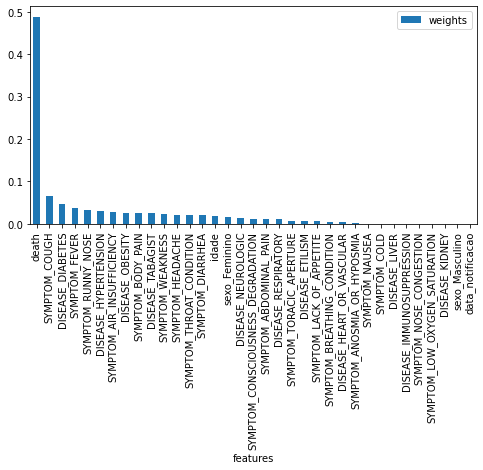

Início do período:  2021-08-19 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.9039201808660161
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9037836310253242
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9036489568692574
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9058600347460157
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


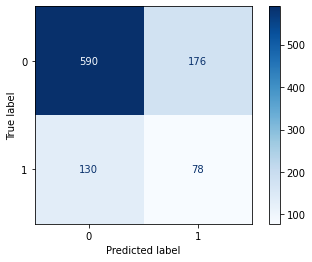

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       766
           1       0.31      0.38      0.34       208

    accuracy                           0.69       974
   macro avg       0.56      0.57      0.57       974
weighted avg       0.71      0.69      0.70       974

roc_auc_score:  0.5726174934725848


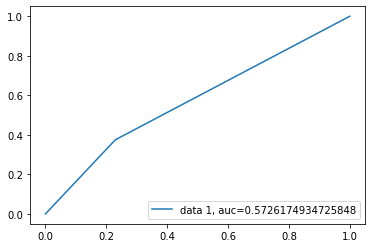

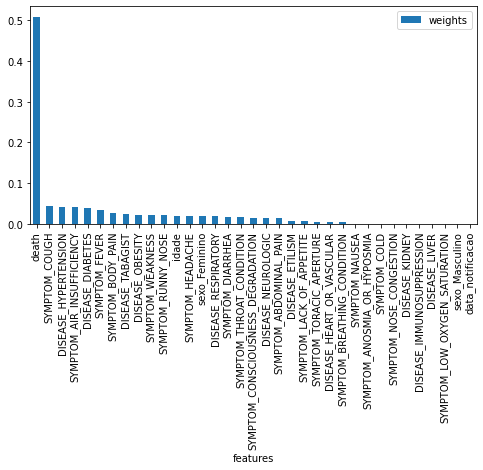

Início do período:  2021-09-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.931833471627557
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9305640412891234
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9322919667651322
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9318241782557226
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


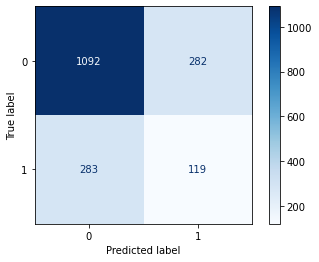

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1374
           1       0.30      0.30      0.30       402

    accuracy                           0.68      1776
   macro avg       0.55      0.55      0.55      1776
weighted avg       0.68      0.68      0.68      1776

roc_auc_score:  0.5453898629125117


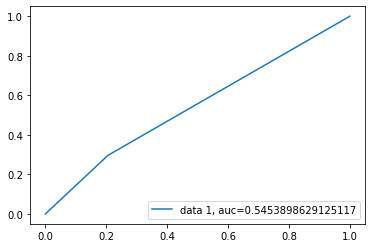

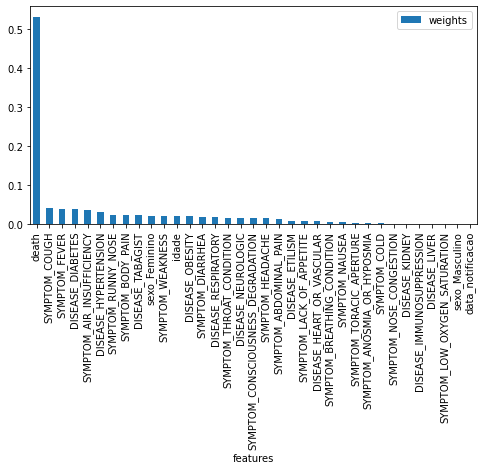

Início do período:  2021-10-18 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.9485792119268097
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9487123344408401
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9503725112589801
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9484049987957501
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


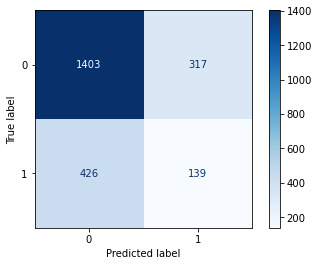

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1720
           1       0.30      0.25      0.27       565

    accuracy                           0.67      2285
   macro avg       0.54      0.53      0.53      2285
weighted avg       0.65      0.67      0.66      2285

roc_auc_score:  0.5308576867668244


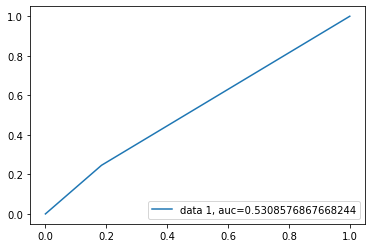

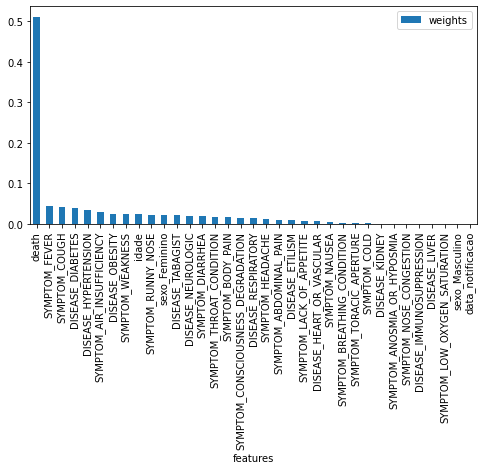

Início do período:  2021-11-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.9261089544366357
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9260369851881242
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9270057049515896
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9265137733725609
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


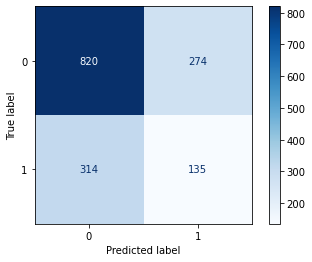

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1094
           1       0.33      0.30      0.31       449

    accuracy                           0.62      1543
   macro avg       0.53      0.53      0.53      1543
weighted avg       0.61      0.62      0.61      1543

roc_auc_score:  0.5251055565282183


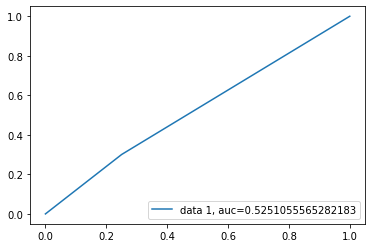

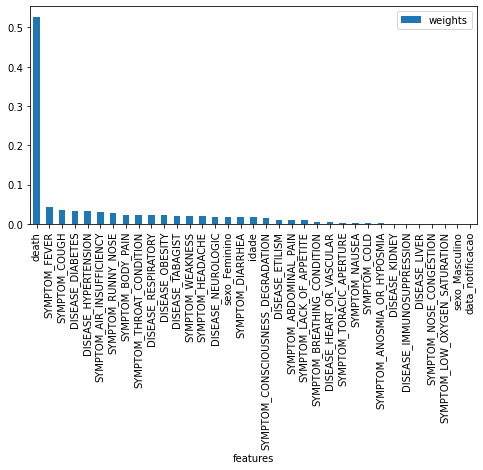

Início do período:  2021-12-17 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.907920017288834
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9086080303234494
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9073140825080465
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.9083306683761243
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
####################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


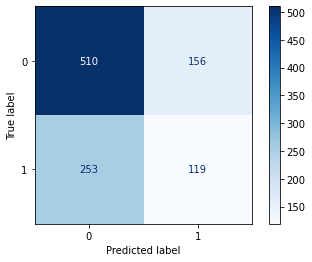

              precision    recall  f1-score   support

           0       0.67      0.77      0.71       666
           1       0.43      0.32      0.37       372

    accuracy                           0.61      1038
   macro avg       0.55      0.54      0.54      1038
weighted avg       0.58      0.61      0.59      1038

roc_auc_score:  0.5428291194420226


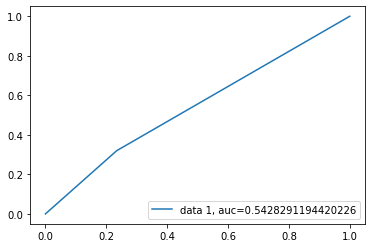

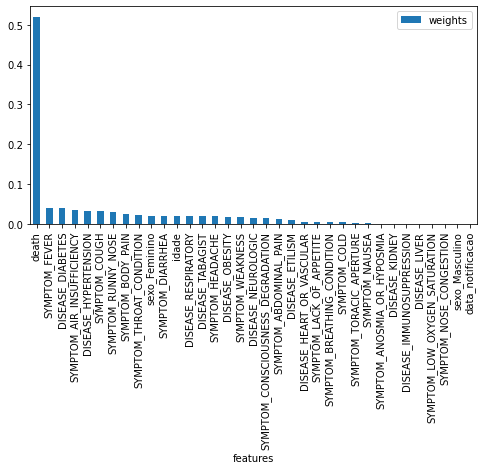

Início do período:  2022-01-16 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.9006930511463844
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9002608553791888
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8996881657848326
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9000165167548501
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


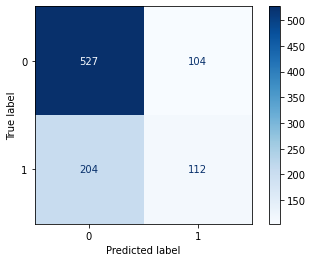

              precision    recall  f1-score   support

           0       0.72      0.84      0.77       631
           1       0.52      0.35      0.42       316

    accuracy                           0.67       947
   macro avg       0.62      0.59      0.60       947
weighted avg       0.65      0.67      0.66       947

roc_auc_score:  0.594806315071516


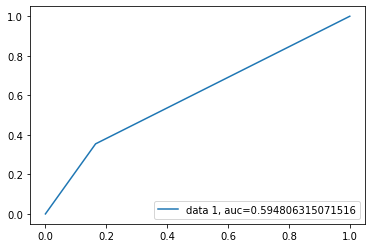

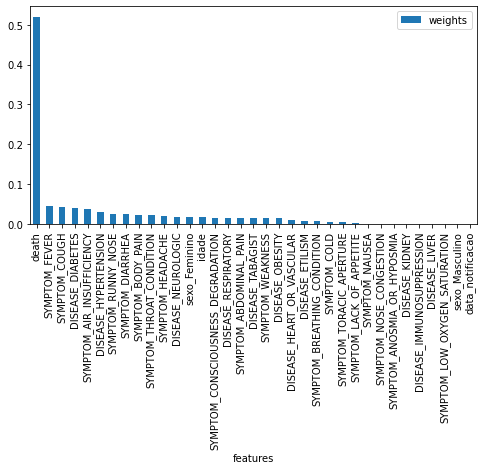

Início do período:  2022-02-15 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8559643908665306
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8569351559501831
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
########################################

########################################

best_score: 0.8566181824639919
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.8586416778823546
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
###################

c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


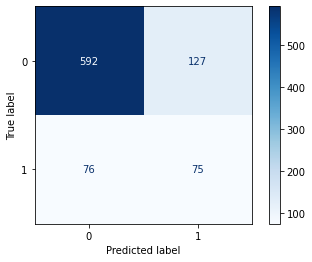

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       719
           1       0.37      0.50      0.42       151

    accuracy                           0.77       870
   macro avg       0.63      0.66      0.64       870
weighted avg       0.80      0.77      0.78       870

roc_auc_score:  0.6600272637677422


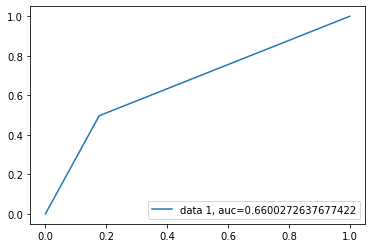

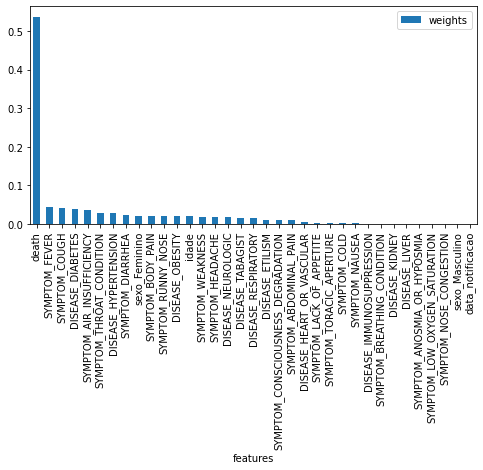

In [14]:
results_accuracy_120_rf, results_f1_120_rf, results_precision_120_rf, results_recall_120_rf, results_roc_auc_120_rf = apply_periodos(120, df)

In [15]:
metricas_accuracy_120_rf = pd.DataFrame(results_accuracy_120_rf)
metricas_accuracy_120_rf.columns = ['accuracy score']
#metricas_accuracy_120_rf
metricas_f1_120_rf = pd.DataFrame(results_f1_120_rf)
metricas_f1_120_rf.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_120_rf
metricas_precision_120_rf = pd.DataFrame(results_precision_120_rf)
metricas_precision_120_rf.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_120_rf
metricas_recall_120_rf = pd.DataFrame(results_recall_120_rf)
metricas_recall_120_rf.columns = ['recall score', 'recall score macro', 'recall score micro', 'recall score weighted']
#metricas_recall_120_rf
metricas_roc_auc_120_rf = pd.DataFrame(results_roc_auc_120_rf)
metricas_roc_auc_120_rf.columns = ['roc_auc score']
#metricas_roc_auc_120_rf
metricas_120_rf = pd.concat([metricas_accuracy_120_rf, metricas_f1_120_rf, metricas_precision_120_rf, metricas_recall_120_rf, metricas_roc_auc_120_rf], axis=1)
metricas_120_rf

accuracy score  f1 score  f1 score macro  f1 score micro  \
0         0.712386  0.543334        0.666713        0.712386   
1         0.642931  0.488166        0.606999        0.642931   
2         0.658167  0.419204        0.588508        0.658167   
3         0.731343  0.415822        0.620691        0.731343   
4         0.696787  0.373444        0.586722        0.696787   
5         0.685614  0.354467        0.573337        0.685614   
6         0.657359  0.329920        0.549876        0.657359   
7         0.663656  0.489104        0.619206        0.663656   
8         0.679957  0.545317        0.649197        0.679957   
9         0.694188  0.513082        0.645089        0.694188   
10        0.684092  0.475117        0.624584        0.684092   
11        0.684525  0.480958        0.627178        0.684525   
12        0.669267  0.485033        0.620723        0.669267   
13        0.693222  0.504515        0.641174        0.693222   
14        0.691910  0.535065        0.652346        0.691910   
15        0.674561  0.541409        0.644600        0.674561   
16        0.641228  0.486826        0.605517        0.641228   
17        0.635854  0.384858        0.563119        0.635854   
18        0.685832  0.337662        0.565870        0.685832   
19        0.681869  0.296389        0.545430        0.681869   
20        0.674836  0.272282        0.531464        0.674836   
21        0.618924  0.314685        0.525386        0.618924   
22        0.605973  0.367852        0.540819        0.605973   
23        0.674762  0.421053        0.597457        0.674762   
24        0.766667  0.424929        0.639285        0.766667   

    f1 score weighted  precision score  precision score macro  \
0            0.712386         0.468122               0.660608   
1            0.642931         0.368715               0.623475   
2            0.658167         0.312937               0.597879   
3            0.731343         0.352840               0.612440   
4            0.696787         0.347044               0.583477   
5            0.685614         0.418367               0.586726   
6            0.657359         0.451713               0.578146   
7            0.663656         0.513559               0.622879   
8            0.679957         0.515714               0.646511   
9            0.694188         0.533156               0.648543   
10           0.684092         0.523810               0.634038   
11           0.684525         0.520853               0.634613   
12           0.669267         0.463132               0.618426   
13           0.693222         0.472017               0.637314   
14           0.691910         0.508224               0.649266   
15           0.674561         0.497727               0.641721   
16           0.641228         0.403326               0.609099   
17           0.635854         0.321053               0.565013   
18           0.685832         0.307087               0.563266   
19           0.681869         0.296758               0.545470   
20           0.674836         0.304825               0.535955   
21           0.618924         0.330073               0.526589   
22           0.605973         0.432727               0.550571   
23           0.674762         0.518519               0.619724   
24           0.766667         0.371287               0.628757   

    precision score micro  precision score weighted  recall score  \
0                0.712386                  0.751342      0.468122   
1                0.642931                  0.758086      0.368715   
2                0.658167                  0.772065      0.312937   
3                0.731343                  0.773964      0.352840   
4                0.696787                  0.714195      0.347044   
5                0.685614                  0.660567      0.418367   
6                0.657359                  0.622496      0.451713   
7                0.663656                  0.656801      0.513559   
8                0.679957  

In [16]:
list_periodos_120 = [['26/02/2020 até 25/06/2020'], ['27/03/2020 até 25/07/2020'], ['26/04/2020 até 24/08/2020'], ['26/05/2020 até 23/09/2020'], 
['25/06/2020 até 23/10/2020'], ['25/07/2020 até 22/11/2020'], ['24/08/2020 até 22/12/2020'], ['23/09/2020 até 21/01/2021'], ['23/10/2020 até 20/02/2021'], 
['22/11/2020 até 22/03/2021'], ['22/12/2020 até 21/04/2021'], ['21/01/2021 até 21/05/2021'], ['20/02/2021 até 20/06/2021'], ['22/03/2021 até 20/07/2021'], 
['21/04/2021 até 19/08/2021'], ['21/05/2021 até 18/09/2021'], ['20/06/2021 até 18/10/2021'], ['20/07/2021 até 17/11/2021'], ['19/08/2021 até 17/12/2021'], 
['18/09/2021 até 16/01/2022'], ['18/10/2021 até 15/02/2022'], ['17/11/2021 até 17/03/2022'], ['17/12/2021 até 16/04/2022'], ['16/01/2022 até 16/05/2022'], 
['15/02/2022 até 15/06/2022']]

In [17]:
coluna_periodos120 = pd.DataFrame(list_periodos_120)
coluna_periodos120.columns = ['Períodos']
metricas_120_rf_final = pd.concat([coluna_periodos120, metricas_120_rf], axis=1)
metricas_120_rf_final

Períodos  accuracy score  f1 score  f1 score macro  \
0   26/02/2020 até 25/06/2020        0.712386  0.543334        0.666713   
1   27/03/2020 até 25/07/2020        0.642931  0.488166        0.606999   
2   26/04/2020 até 24/08/2020        0.658167  0.419204        0.588508   
3   26/05/2020 até 23/09/2020        0.731343  0.415822        0.620691   
4   25/06/2020 até 23/10/2020        0.696787  0.373444        0.586722   
5   25/07/2020 até 22/11/2020        0.685614  0.354467        0.573337   
6   24/08/2020 até 22/12/2020        0.657359  0.329920        0.549876   
7   23/09/2020 até 21/01/2021        0.663656  0.489104        0.619206   
8   23/10/2020 até 20/02/2021        0.679957  0.545317        0.649197   
9   22/11/2020 até 22/03/2021        0.694188  0.513082        0.645089   
10  22/12/2020 até 21/04/2021        0.684092  0.475117        0.624584   
11  21/01/2021 até 21/05/2021        0.684525  0.480958        0.627178   
12  20/02/2021 até 20/06/2021        0.669267  0.485033        0.620723   
13  22/03/2021 até 20/07/2021        0.693222  0.504515        0.641174   
14  21/04/2021 até 19/08/2021        0.691910  0.535065        0.652346   
15  21/05/2021 até 18/09/2021        0.674561  0.541409        0.644600   
16  20/06/2021 até 18/10/2021        0.641228  0.486826        0.605517   
17  20/07/2021 até 17/11/2021        0.635854  0.384858        0.563119   
18  19/08/2021 até 17/12/2021        0.685832  0.337662        0.565870   
19  18/09/2021 até 16/01/2022        0.681869  0.296389        0.545430   
20  18/10/2021 até 15/02/2022        0.674836  0.272282        0.531464   
21  17/11/2021 até 17/03/2022        0.618924  0.314685        0.525386   
22  17/12/2021 até 16/04/2022        0.605973  0.367852        0.540819   
23  16/01/2022 até 16/05/2022        0.674762  0.421053        0.597457   
24  15/02/2022 até 15/06/2022        0.766667  0.424929        0.639285   

    f1 score micro  f1 score weighted  precision score  precision score macro  \
0         0.712386           0.712386         0.468122               0.660608   
1         0.642931           0.642931         0.368715               0.623475   
2         0.658167           0.658167         0.312937               0.597879   
3         0.731343           0.731343         0.352840               0.612440   
4         0.696787           0.696787         0.347044               0.583477   
5         0.685614           0.685614         0.418367               0.586726   
6         0.657359           0.657359         0.451713               0.578146   
7         0.663656           0.663656         0.513559               0.622879   
8         0.679957           0.679957         0.515714               0.646511   
9         0.694188           0.694188         0.533156               0.648543   
10        0.684092           0.684092         0.523810               0.634038   
11        0.684525           0.684525         0.520853               0.634613   
12        0.669267           0.669267         0.463132               0.618426   
13        0.693222           0.693222         0.472017               0.637314   
14        0.691910           0.691910         0.508224               0.649266   
15        0.674561           0.674561         0.497727               0.641721   
16        0.641228           0.641228         0.403326               0.609099   
17        0.635854           0.635854         0.321053               0.565013   
18        0.685832           0.685832         0.307087               0.563266   
19        0.681869           0.681869         0.296758               0.545470   
20        0.674836           0.674836         0.304825               0.535955   
21        0.618924           0.618924         0.330073               0.526589   
22        0.605973           0.605973         0.432727               0.550571   
23        0.674762           0.674762         0.518519               0.619724   
24        0.766667           0.766667        